In [1]:
# import libraries
import numpy as np
import awkward as ak
import pandas as pd
import os, h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from jason import jason_plotting as plotting
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('/Users/jasonwu/Programs/codes/def.mplstyle')
plotting.plot_prettier(dpi=400,usetex=False)
%matplotlib inline
import uproot

# Reading file

In [2]:
file = uproot.open("/Users/jasonwu/Programs/Fermilab/data/test_tracks/root/230711/pf.neu_0p1_4GeV.10k.root")

In [3]:
file.keys()

['LDMX_Events;10', 'LDMX_Events;9', 'LDMX_Run;1']

In [4]:
file['LDMX_Events'].keys()

['EventHeader',
 'EventHeader/eventNumber_',
 'EventHeader/run_',
 'EventHeader/timestamp_',
 'EventHeader/timestamp_/timestamp_.fSec',
 'EventHeader/timestamp_/timestamp_.fNanoSec',
 'EventHeader/weight_',
 'EventHeader/isRealData_',
 'EventHeader/intParameters_',
 'EventHeader/intParameters_/intParameters_.first',
 'EventHeader/intParameters_/intParameters_.second',
 'EventHeader/floatParameters_',
 'EventHeader/floatParameters_/floatParameters_.first',
 'EventHeader/floatParameters_/floatParameters_.second',
 'EventHeader/stringParameters_',
 'EventHeader/stringParameters_/stringParameters_.first',
 'EventHeader/stringParameters_/stringParameters_.second',
 'PFEcalClusters_pf',
 'PFEcalClusters_pf/PFEcalClusters_pf.hitIDs_',
 'PFEcalClusters_pf/PFEcalClusters_pf.energy_',
 'PFEcalClusters_pf/PFEcalClusters_pf.nHits_',
 'PFEcalClusters_pf/PFEcalClusters_pf.centroidX_',
 'PFEcalClusters_pf/PFEcalClusters_pf.centroidY_',
 'PFEcalClusters_pf/PFEcalClusters_pf.centroidZ_',
 'PFEcalCluste

In [5]:
can_erg = file['LDMX_Events']['PFCandidates_pf/PFCandidates_pf.energy_'].array(library='np')
ecal_erg = file['LDMX_Events']['PFCandidates_pf/PFCandidates_pf.ecalEnergy_'].array(library='np')
hcal_erg = file['LDMX_Events']['PFCandidates_pf/PFCandidates_pf.hcalEnergy_'].array(library='np')
truth_track_erg = file['LDMX_Events']['PFTruthTarget_pf/PFTruthTarget_pf.energy_'].array(library='np')
truth_ecal_erg = file['LDMX_Events']['PFTruthEcal_pf/PFTruthEcal_pf.energy_'].array(library='np')
truth_hcal_erg = file['LDMX_Events']['PFTruthHcal_pf/PFTruthHcal_pf.energy_'].array(library='np')
len(can_erg), len(ecal_erg), len(hcal_erg), len(truth_track_erg), len(truth_ecal_erg), len(truth_hcal_erg)

(10000, 10000, 10000, 10000, 10000, 10000)

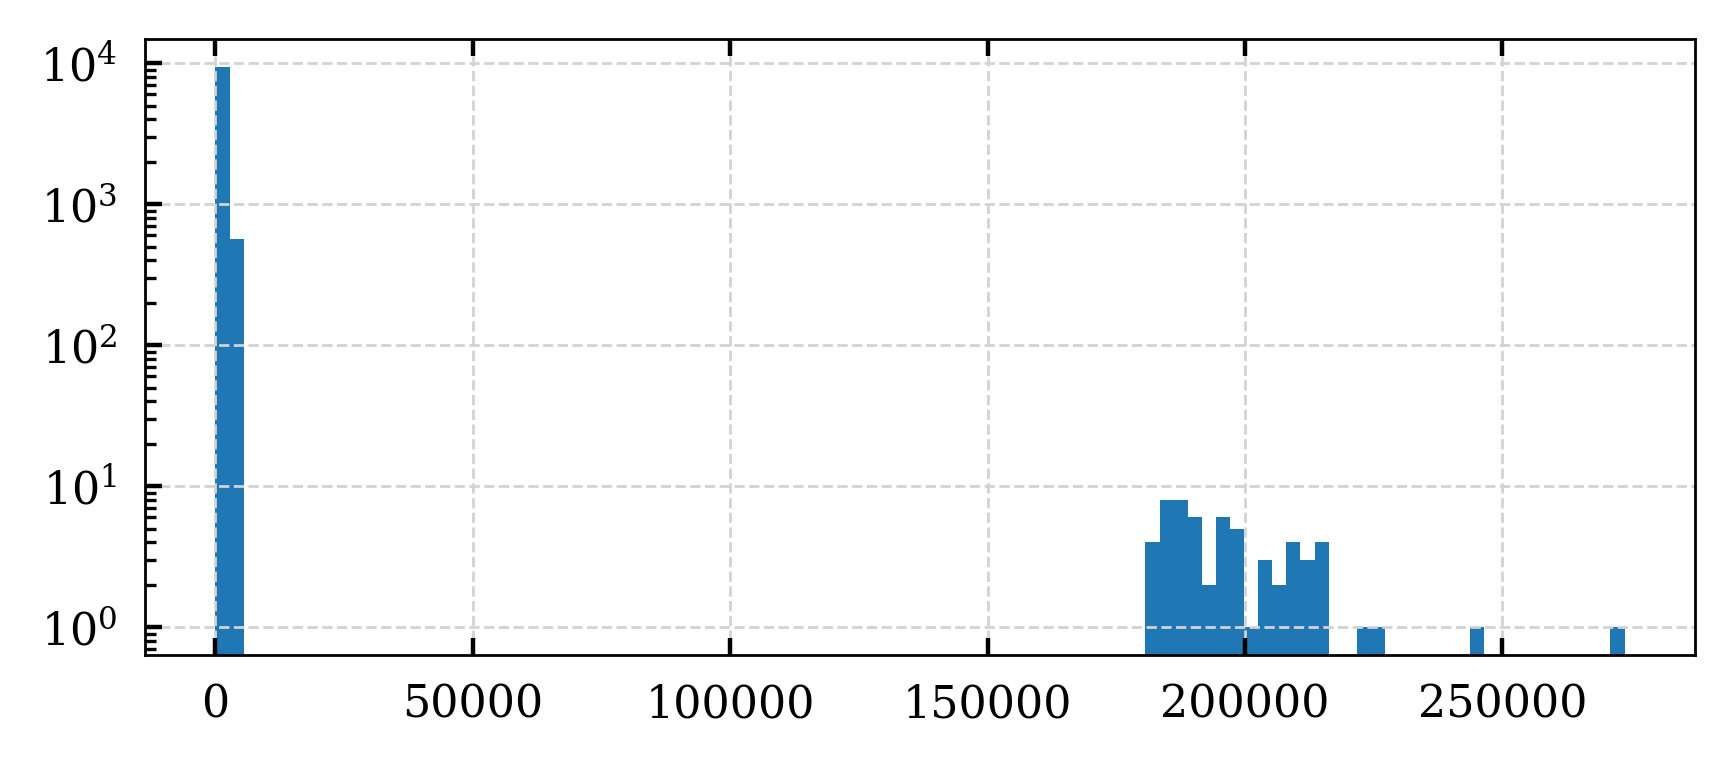

In [6]:
fig, ax = plt.subplots(figsize=(5, 2))
a = ak.to_numpy(ak.ravel(file['LDMX_Events']['PFCandidates_pf/PFCandidates_pf.hcalEnergy_'].array(library='ak')))
ax.hist(a)
ax.set_yscale('log')
plt.show()

# Function

## Get Properties

In [7]:
# # old function
# def get_data(file_name = 'pf.ele_0p1_4GeV.10k.root',
#              root_trial = '230711',
#              root_dir = '/Users/jasonwu/Programs/Fermilab/data/test_tracks/root',
#              included_branches = ['PFEcalClusters_pf', 'PFHcalClusters_pf', 'PFTracks_pf', 'PFCandidates_pf', 'PFTruth_pf', 'PFTruthTarget_pf', 'PFTruthEcal_pf', 'PFTruthHcal_pf']):
#     file = uproot.open(f'{root_dir}/{root_trial}/{file_name}')
#     events = file['LDMX_Events']
#     # all the keys in events
#     keys = np.array(events.keys())
#     # branches
#     branch_mask = np.array([0 if '/' in branch else 1 for branch in keys]).astype(bool)
#     branches = keys[branch_mask]
#     branch_ind = np.append(np.where(branch_mask == 1)[0], -1)

#     # a function to omit strings and empty arrays
#     def check_str(obj):
#         if np.ndim(obj) == 0:  # if scalar
#             if isinstance(obj, str):  # if string
#                 return 1
#             else:  # if not string
#                 return 0
#         else:  # if vector
#             if len(obj) == 0:  # and isn't empty
#                 return -1
#             else:
#                 return check_str(obj[0])
            
                 
#     prop_dict = {}
#     for i in range(len(branches)):
#         branch = branches[i]
#         # if branch is to be included
#         if branch in included_branches:
#             branch_nodes = keys[branch_ind[i]+1:] if branch_ind[i+1] == -1 else keys[branch_ind[i]+1 : branch_ind[i+1]]
#             for branch_node in branch_nodes:
#                 prop = events[branch_node].array(library='np')
                
#                 match check_str(prop):
#                     case 1:  # omit strings
#                         print(f'Prop omitted at {branch_node} due to string')
#                         continue
#                     case -1:  # empty arrays
#                         print(f'Prop zeroed at {branch_node} from empty arrays')
#                         try:
#                             prop_flat = np.zeros_like(prop_dict.values()[-1])
#                         except:
#                             prop_flat = np.zeros_like(prop)
#                         prop_dict[branch_node.split('/')[1].replace('_pf', '')[:-1].replace('.', '_')] = prop_flat
#                         continue

#                 # flatten the array
#                 try:
#                     prop_flat = np.array([n if np.ndim(n)==0 else (0 if len(n)==0 else n[0]) for n in prop])
#                 except:
#                     prop_flat = np.hstack(prop)
#                     print(f'Principle element failed at {branch_node}, stacking length {len(prop)} into {len(prop_flat)}')
                    
#                 if isinstance(prop_flat[0], uproot.STLVector):  # omit vectors
#                     print(f'Prop omitted at {branch_node} due to vector')
#                     continue
#                 if len(prop) == 0:  # omit empty lists
#                     print(f'Prop omitted at {branch_node} due to empty')
#                 prop_dict[branch_node.split('/')[1].replace('_pf', '')[:-1].replace('.', '_')] = prop_flat

#     return prop_dict

In [8]:
def get_data(file_name = 'pf.ele_0p1_4GeV.10k.root',
             root_trial = '230711',
             root_dir = '/Users/jasonwu/Programs/Fermilab/data/test_tracks/root',
             # the branches to include in the output
             included_branches = ['PFEcalClusters_pf', 'PFHcalClusters_pf', 'PFTracks_pf', 'PFCandidates_pf', 'PFTruthTarget_pf', 'PFTruthEcal_pf', 'PFTruthHcal_pf'],
             # if True, generates leading cluster properties
             lead_clust = False,
             # the branches to do leading cluster on
             lead_clust_branches = ['PFEcalClusters_pf', 'PFHcalClusters_pf'],
             lead_clust_override = False,
             # if True, prints type and number of points in each property
             verbose = False):
    file = uproot.open(f'{root_dir}/{root_trial}/{file_name}')
    events = file['LDMX_Events']
    # all the keys in events
    keys = np.array(events.keys())
    # branches
    branch_mask = np.array([0 if '/' in branch else 1 for branch in keys]).astype(bool)
    branches = keys[branch_mask]
    branch_ind = np.append(np.where(branch_mask == 1)[0], -1)

    if lead_clust_override:
        suffix_new = ''
        suffix_og = '_og'
    else:
        suffix_new = '_lc'
        suffix_og = ''
                 
    prop_dict = {}
    for i in range(len(branches)):
        branch = branches[i]
        
        # check if within included branch
        if branch in included_branches:
            # get all the nodes of the branch
            branch_nodes = keys[branch_ind[i]+1:] if branch_ind[i+1] == -1 else keys[branch_ind[i]+1 : branch_ind[i+1]]

            # get the energy indices for leading cluster anlaysis
            if lead_clust and (branch in lead_clust_branches):
                energy_node = f'{branch}/{branch}.energy_'  # string of the energy node
                # the awkward array corresponding to energy
                energy_prop = events[energy_node].array(library='ak')
                energy_prop = ak.values_astype(energy_prop, np.float64)
                # the indices corresponding to maximum energy (in case unsorted)
                max_ind = ak.argmax(energy_prop, axis=1, keepdims=True, mask_identity=True)
                
            # for each node in the branch
            for branch_node in branch_nodes:
                # make the awkward array
                prop = events[branch_node].array(library='ak')
                # pad the array with at least one entry
                prop = ak.pad_none(prop, 1, axis=1)

                # check if consisting of empty arrays
                if len(ak.ravel(prop)) == 0 or not ak.any(ak.ravel(prop)):  # effectively empty
                    # flatten the array into zeros
                    if verbose: print(f'Empty array at {branch_node}, reduced to zeroes')
                    prop_flat = np.zeros(len(prop))
                    if verbose: print(prop_flat.shape)

                    prop_dict[branch_node.split('/')[1].replace('_pf', '')[:-1].replace('.', '_')] = prop_flat
                elif len(ak.ravel(prop)) == len(prop):  # effectively one-dimensional
                    if verbose: print(f'One-dimensional array at {branch_node}, reduced to numpy')
                    prop_flat = ak.to_numpy(ak.ravel(prop), allow_missing=True).astype(float).filled(np.nan)
                    if verbose: print(prop_flat.shape)

                    prop_dict[branch_node.split('/')[1].replace('_pf', '')[:-1].replace('.', '_')] = prop_flat
                else:
                    # if the array is truly jagged
                    if verbose: print(f'Jagged/partially empty array at {branch_node}')
                    prop_flat = prop
                    if verbose: print(prop_flat.type)

                    # construct a leading cluster array
                    if lead_clust and (branch in lead_clust_branches):
                        # mask the array with max energy indices
                        max_prop = prop_flat[ak.from_regular(max_ind)]
                        # flatten, convert to numpy array, and fill with nan
                        max_prop_flat = ak.to_numpy(ak.ravel(max_prop), allow_missing=True).astype(float)
                        max_prop_flat = max_prop_flat.filled(np.nan)
                        prop_dict[branch_node.split('/')[1].replace('_pf', '')[:-1].replace('.', '_') + suffix_new] = max_prop_flat
                        prop_dict[branch_node.split('/')[1].replace('_pf', '')[:-1].replace('.', '_') + suffix_og] = prop_flat
                    else:
                        prop_dict[branch_node.split('/')[1].replace('_pf', '')[:-1].replace('.', '_')] = prop_flat

    return prop_dict

## Dictionaries

In [9]:
labels_keys = 'electrons neutrons photons pions protons electrons_hcal neutrons_hcal photons_hcal pions_hcal protons_hcal'.split(' ')
labels_values = [
    r'Electrons $e^{\minus}$',
    r'Neutrons $n^{o}$',
    r'Photons $\gamma$',
    r'Pions $\pi^{\minus}$',
    r'Protons $p^{\plus}$',
    r'Electrons $e^{\minus}$ HCal',
    r'Neutrons $n^{o}$ HCal',
    r'Photons $\gamma$ HCal',
    r'Pions $\pi^{\minus}$ HCal',
    r'Protons $p^{\plus}$ HCal'
]

labels_dict = {labels_keys[i]: labels_values[i] for i in range(len(labels_keys))}

# HCal particles
hcal_particles_dict = {
    'electrons_hcal': None,
    'photons_hcal': None,
    'neutrons_hcal': None,
    'pions_hcal': None,
    'protons_hcal': None
}

# ECal + HCal particles
both_particles_dict = {
    'electrons': None,
    'photons': None,
    'neutrons': None,
    'pions': None,
    'protons': None
}

In [10]:
# initiate a particle class
class Particles():
    def __init__(self, prop_dict, zero_on='PFTruthTarget_energy'):
        # a list of properties
        self.propdict = prop_dict
        self._clean_props(zero_on)
    
    # clean the data set
    def _clean_props(self, zero_on='PFTruthTarget_energy'):
        # remove on column
        if isinstance(zero_on, list):
            # invalid energy values
            zero_bool_mask = np.array(self.propdict[zero_on[0]] <= 0)
            for zero_col in zero_on[1:]:
                zero_bool_mask = np.logical_or(zero_bool_mask, np.array(self.propdict[zero_col] <= 0))
        else:
            zero_bool_mask = np.array(self.propdict[zero_on] <= 0)
            
        print(f'{np.sum(zero_bool_mask)} values removed from {zero_on}')
        
        for prop in list(self.propdict.keys()):
            nan_bool_mask = np.isnan(self.propdict[prop])
            if np.any(nan_bool_mask):
                print(f'{np.sum(nan_bool_mask):<10} NaN values for {prop}')
                # set the values to zero
                self.propdict[prop][np.isnan(self.propdict[prop])] = 0
            self.propdict[prop] = self.propdict[prop][~zero_bool_mask]
                
        print('\n')

        # also replace dictionary labels
        self.propdict['PFCandidates_ecalCalEnergy'] = self.propdict.pop('PFCandidates_ecalEnergy')
        self.propdict['PFCandidates_ecalEnergy'] = self.propdict.pop('PFCandidates_ecalRawEnergy')
        self.propdict['PFCandidates_hcalCalEnergy'] = self.propdict.pop('PFCandidates_hcalEnergy')
        self.propdict['PFCandidates_hcalEnergy'] = self.propdict.pop('PFCandidates_hcalRawEnergy')
    
    # return a property
    def get(self, prop = None):
        if prop is not None:  # if specific property(ies) are given
            if isinstance(prop, list):
                prop_list = []
                for single_prop in prop:
                    prop_list.append(self.propdict[single_prop])
                return prop_list
            else:
                assert prop in list(self.propdict.keys())
                return self.propdict[prop]
        else:
            return self.propdict
    
    # account for mass of particle
    def acc_mass(self, mass, columns=[]):
        # subtract mass
        for column in columns:
            # clipped to zero
            # therefore, 0 -> 0, mass + energy -> energy
            self.propdict[column] = np.clip(self.propdict[column] - mass, 0, None)
    
    # return a list of all properties
    def list_props(self):        
        print(f'{"Property Name":<30}{"Number of Entries":<20}{"Unique Entries":<20}{"Range":<30}{"Mean"}')
        
        for prop in list(self.propdict.keys()):
            print(f'{prop: <30}{len(self.propdict[prop]):<20}{len(np.unique(self.propdict[prop])):<8}\
            {np.nanmin(self.propdict[prop]):<10.2f}{np.nanmax(self.propdict[prop]):>8.2f}\
            {np.nanmean(self.propdict[prop]):<.2f}')
        print('\n')
        return list(self.propdict.keys())
    
    # apply a correction to the ecal and hcal energy measurements
    def o1corr_energy(self, verbose=True, scheme='nearest',  # three schemes 'none', 'nearest' and 'spline'
                      energy_bins_ecal=[0, 6e3], o1corr_ecal=[1],
                      energy_bins_hcal=[0, 6e3], o1corr_hcal=[1],
                      numbins=20, gev=True, label=labels_dict['photons']):
        # correct the energies
        match scheme:  # different schemes to handle values outside of measured bins
            case 'none':  # set to NaN, breaks plots
                # ecal
                o1corr_ecal = pd.cut(self.get('PFCandidates_ecalEnergy'), bins=energy_bins_ecal,
                                     include_lowest=True, labels=o1corr_ecal).to_numpy()
                # hcal
                o1corr_hcal = pd.cut(self.get('PFCandidates_hcalEnergy'), bins=energy_bins_hcal,
                                     include_lowest=True, labels=o1corr_hcal).to_numpy()
            case 'nearest':  # sets to value of nearest bin
                def nearest_cut(data, bins=[0, 6e3], labels=[1]):
                    # assigns labels to data based on bins
                    label_ind = np.digitize(data, bins=bins, right=True)
                    # contains 0 and len(labels)
                    label_ind[label_ind == 0] = 1  # label_ind will start at 1
                    label_ind[label_ind == len(bins)] = len(labels)  # set to maximum ind
                    return labels[label_ind - 1]
                # ecal
                o1corr_ecal = nearest_cut(self.get('PFCandidates_ecalEnergy'), bins=energy_bins_ecal, labels=o1corr_ecal)
                # hcal
                o1corr_hcal = nearest_cut(self.get('PFCandidates_hcalEnergy'), bins=energy_bins_hcal, labels=o1corr_hcal)
            case 'spline':
                def spline_cut(data, bins=[0, 6e3], labels=[1]):
                    # construct spline object for bin centers
                    bin_centers = [(a + b) / 2 for a, b in zip(bins[::], bins[1::])] # average of two consecutive elements in bins
                    # calculate splined values for data
                    splined_coeff, _ = plotting.spline_xy(bin_centers, labels, data)
                    return splined_coeff
                    
                # ecal
                o1corr_ecal = spline_cut(self.get('PFCandidates_ecalEnergy'), bins=energy_bins_ecal, labels=o1corr_ecal)
                # hcal
                o1corr_hcal = spline_cut(self.get('PFCandidates_hcalEnergy'), bins=energy_bins_hcal, labels=o1corr_hcal)
                
        energy_o1corr_ecal = self.get('PFCandidates_ecalEnergy') * o1corr_ecal
        energy_o1corr_hcal = self.get('PFCandidates_hcalEnergy') * o1corr_hcal
        
        
        # total
        energy_o1corr_total = energy_o1corr_ecal + energy_o1corr_hcal
        
        # set the dictionary entries
        self.propdict['PFCandidates_ecalEnergy_o1corr'] = energy_o1corr_ecal
        self.propdict['PFCandidates_hcalEnergy_o1corr'] = energy_o1corr_hcal
        self.propdict['PFCandidates_energy_o1corr'] = energy_o1corr_total
        
        # O(1) correction comparison plot with both energies
        if verbose:
            fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
            # set the truth energy depending on the type of particle simulation
            if (label is not None) and \
               ('HCal' in label):
                # if the particle went through both ecal and hcal
                print('HCal energy set to truth')
                energy_truth_total = self.get('PFTruthHcal_energy')  # the pre-hcal energy is set to truth
            else:
                print('Target energy set to truth')
                energy_truth_total = self.get('PFTruthTarget_energy')  # the pre-target energy is set to truth

            if gev:  # plot x axis in gev instead
                plt.xlim([0, 4])
                plt.xlabel('Truth Total Energy [GeV]')
                x = energy_truth_total/1e3
                textx = 3.5
            else:  # plot x axis in mev
                plt.xlim([0, 4000])
                plt.xlabel('Truth Total Energy [MeV]')
                x = energy_truth_total
                textx = 3500
            y1 = self.get('PFCandidates_energy')/energy_truth_total  # measured ratio
            y2 = energy_o1corr_total/energy_truth_total  # reconstructed ratio
            _ = plotting.percentile(x, y1, numbins=numbins, style=style,
                                    color='red', label='Measured', textpos=[textx, 1.5])
            _ = plotting.percentile(x, y2, numbins=numbins, style=style,
                                    color='blue', label='$\mathcal{O}(1)$ Reconstructed')
            plt.ylabel('Reconstructed / Truth Total Energy', fontsize=10)
            plt.legend(loc='upper right')
            plt.ylim([0, 2])
            plt.annotate(text=label, xy=(-50, -30), xycoords='axes points', fontsize=7, weight='bold')

        return energy_o1corr_ecal, energy_o1corr_hcal, energy_o1corr_total

## Load files

In [11]:
import os

# all branches
included_branches = ['PFEcalClusters_pf', 'PFHcalClusters_pf', 'PFTracks_pf', 'PFCandidates_pf', 'PFTruthTarget_pf', 'PFTruthEcal_pf', 'PFTruthHcal_pf']
# # sub branches
# included_branches = ['PFTracks_pf', 'PFCandidates_pf', 'PFTruth_pf', 'PFTruthTarget_pf', 'PFTruthEcal_pf', 'PFTruthHcal_pf']
root_dir = '/Users/jasonwu/Programs/Fermilab/data/test_tracks/root'
root_trial = '230711'

np.sort(os.listdir(f'{root_dir}/{root_trial}'))

array(['pf.ele_0p1_4GeV.10k.HCal.root', 'pf.ele_0p1_4GeV.10k.root',
       'pf.neu_0p1_4GeV.10k.HCal.root', 'pf.neu_0p1_4GeV.10k.root',
       'pf.pho_0p1_4GeV.10k.HCal.root', 'pf.pho_0p1_4GeV.10k.root',
       'pf.piM_0p1_4GeV.10k.HCal.root', 'pf.piM_0p1_4GeV.10k.root',
       'pf.pro_0p1_4GeV.10k.HCal.root', 'pf.pro_0p1_4GeV.10k.root',
       'readme.txt'], dtype='<U29')

In [12]:
a = get_data(file_name='pf.ele_0p1_4GeV.10k.root', root_trial=root_trial, included_branches=included_branches)
len(a['PFTruthTarget_energy']), len(a['PFTruthEcal_energy'])

(10000, 10000)

In [13]:
electrons_hcal = Particles(get_data(file_name='pf.ele_0p1_4GeV.10k.HCal.root', root_trial=root_trial, included_branches=included_branches), zero_on='PFTruthHcal_energy')
photons_hcal = Particles(get_data(file_name='pf.pho_0p1_4GeV.10k.HCal.root', root_trial=root_trial, included_branches=included_branches), zero_on='PFTruthHcal_energy')
neutrons_hcal = Particles(get_data(file_name='pf.neu_0p1_4GeV.10k.HCal.root', root_trial=root_trial, included_branches=included_branches), zero_on='PFTruthHcal_energy')
pions_hcal = Particles(get_data(file_name='pf.piM_0p1_4GeV.10k.HCal.root', root_trial=root_trial, included_branches=included_branches), zero_on='PFTruthHcal_energy')
protons_hcal = Particles(get_data(file_name='pf.pro_0p1_4GeV.10k.HCal.root', root_trial=root_trial,
                                  included_branches=included_branches,
                                  lead_clust=True, lead_clust_branches=['PFTruthHcal_pf'],
                                  lead_clust_override=True),
                         zero_on='PFTruthHcal_energy')

0 values removed from PFTruthHcal_energy
10000      NaN values for PFEcalClusters_centroidX
10000      NaN values for PFEcalClusters_centroidY
10000      NaN values for PFEcalClusters_centroidZ
10000      NaN values for PFEcalClusters_rmsX
10000      NaN values for PFEcalClusters_rmsY
10000      NaN values for PFEcalClusters_rmsZ
3          NaN values for PFEcalClusters_DXDZ
3          NaN values for PFEcalClusters_DYDZ
3          NaN values for PFEcalClusters_errDXDZ
3          NaN values for PFEcalClusters_errDYDZ
1          NaN values for PFHcalClusters_centroidX
1          NaN values for PFHcalClusters_centroidY
1          NaN values for PFHcalClusters_centroidZ
2          NaN values for PFHcalClusters_rmsX
2          NaN values for PFHcalClusters_rmsY
7          NaN values for PFHcalClusters_rmsZ
10000      NaN values for PFCandidates_ecalClusterX
10000      NaN values for PFCandidates_ecalClusterY
10000      NaN values for PFCandidates_ecalClusterZ
10000      NaN values for PFCan

In [14]:
# get_data(file_name='pf.pro_0p1_4GeV.10k.root', root_trial=root_trial,
#          included_branches=included_branches, lead_clust=True, lead_clust_branches=['PFTruthEcal_pf', 'PFTruthTarget_pf'],
#          lead_clust_override=True)

In [15]:
# only remove zero values for ecal (all absorbed by ecal)
# this is the total energy for electrons and photons
target_ecal_ind = ['PFTruthTarget_energy', 'PFTruthEcal_energy']
electrons = Particles(get_data(file_name='pf.ele_0p1_4GeV.10k.root', root_trial=root_trial,
                               included_branches=included_branches, lead_clust=True, lead_clust_branches=['PFTruthEcal_pf', 'PFTruthTarget_pf'],
                               lead_clust_override=True), zero_on=target_ecal_ind)
photons = Particles(get_data(file_name='pf.pho_0p1_4GeV.10k.root', root_trial=root_trial, included_branches=included_branches), zero_on=target_ecal_ind)

# remove zero values for both
# target_ecal_hcal_ind = ['PFTruthTarget_energy', 'PFTruthEcal_energy', 'PFTruthHcal_energy']
neutrons = Particles(get_data(file_name='pf.neu_0p1_4GeV.10k.root', root_trial=root_trial, included_branches=included_branches), zero_on=target_ecal_ind)
pions = Particles(get_data(file_name='pf.piM_0p1_4GeV.10k.root', root_trial=root_trial, included_branches=included_branches), zero_on=target_ecal_ind)
protons = Particles(get_data(file_name='pf.pro_0p1_4GeV.10k.root', root_trial=root_trial, included_branches=included_branches), zero_on=target_ecal_ind)

0 values removed from ['PFTruthTarget_energy', 'PFTruthEcal_energy']
2          NaN values for PFEcalClusters_centroidX
2          NaN values for PFEcalClusters_centroidY
2          NaN values for PFEcalClusters_centroidZ
3          NaN values for PFEcalClusters_rmsX
5          NaN values for PFEcalClusters_rmsY
4          NaN values for PFEcalClusters_rmsZ
6509       NaN values for PFHcalClusters_centroidX
6509       NaN values for PFHcalClusters_centroidY
6509       NaN values for PFHcalClusters_centroidZ
6886       NaN values for PFHcalClusters_rmsX
6952       NaN values for PFHcalClusters_rmsY
6925       NaN values for PFHcalClusters_rmsZ
35         NaN values for PFTracks_id
35         NaN values for PFTracks_edep
35         NaN values for PFTracks_time
35         NaN values for PFTracks_px
35         NaN values for PFTracks_py
35         NaN values for PFTracks_pz
35         NaN values for PFTracks_energy
35         NaN values for PFTracks_x
35         NaN values for PFTracks_y
3

In [16]:
# column names
_ = neutrons.list_props()

Property Name                 Number of Entries   Unique Entries      Range                         Mean
PFEcalClusters_hitIDs         10000               1                   0.00          0.00            0.00
PFEcalClusters_energy         10000               7933                0.00      13974.87            1108.92
PFEcalClusters_nHits          10000               95                  0.00        109.00            17.55
PFEcalClusters_centroidX      10000               8017                -253.37     257.83            1.11
PFEcalClusters_centroidY      10000               7963                -232.62     244.45            0.67
PFEcalClusters_centroidZ      10000               7753                0.00        749.11            418.73
PFEcalClusters_rmsX           10000               7788                0.00        204.65            27.50
PFEcalClusters_rmsY           10000               7778                0.00        175.52            27.36
PFEcalClusters_rmsZ           10000            

## Account for masses

Subtract the rest mass from the truth energy.

Truth energy measured by the scoring plane is both kinetic and potential energy.

In [17]:
# define the particle mass [MeV]
electron_mass = 0.511
neutron_mass = 939.56
photon_mass = 0
pion_mass = 139.57
proton_mass = 938.27

# subtract rest mass from the total energies, leaving kinetic
# do not include measured energies
hcal_cols = 'PFTruthHcal_energy'.split(' ')
full_cols = 'PFTruthTarget_energy PFTruthEcal_energy PFTruthHcal_energy PFCandidates_truthEnergy'.split(' ')

# subtract the mass
electrons_hcal.acc_mass(electron_mass, columns=hcal_cols)
electrons.acc_mass(electron_mass, columns=full_cols)
neutrons_hcal.acc_mass(neutron_mass, columns=hcal_cols)
neutrons.acc_mass(neutron_mass, columns=full_cols)
photons_hcal.acc_mass(photon_mass, columns=hcal_cols)
photons.acc_mass(photon_mass, columns=full_cols)
pions_hcal.acc_mass(pion_mass, columns=hcal_cols)
pions.acc_mass(pion_mass, columns=full_cols)
protons_hcal.acc_mass(proton_mass, columns=hcal_cols)
protons.acc_mass(proton_mass, columns=full_cols)

In [18]:
hcal_particles_dict['electrons_hcal'] = electrons_hcal
hcal_particles_dict['photons_hcal'] = photons_hcal
hcal_particles_dict['neutrons_hcal'] = neutrons_hcal
hcal_particles_dict['pions_hcal'] = pions_hcal
hcal_particles_dict['protons_hcal'] = protons_hcal

both_particles_dict['electrons'] = electrons
both_particles_dict['photons'] = photons
both_particles_dict['neutrons'] = neutrons
both_particles_dict['pions'] = pions
both_particles_dict['protons'] = protons

# Energy Correction

Load the weights

In [19]:
ele_energy_bins_ecal = np.array([0., 500., 1000., 1500., 2000., 2500., 3000., 3500., 4000., 4500., 5000., 5500., 6000.])
avg_o1corr_ecal = np.array([1.18987852, 1.02952459, 0.99478492, 0.98629969, 0.98273146, 0.9760755 , 0.96378225, 0.93880792, 0.87393644, 0.80097519, 0.72741938, 0.66352241])
ext_bins_hcal = np.array([0., 50., 100., 150., 200., 250., 300., 350., 400., 450., 500., 550., 600., 650.]) * 10
pe_o1corr_hcal = np.array([8.4280355 ,  7.37783051,  7.75777364,  8.53401804,  9.46895409, 10.44644213, 10.46670198,  9.70749855,  8.87022924,  8.25057888, 8.25057888,  8.25057888,  8.25057888])

In [22]:
scheme = 'spline'
style = 1

Electrons and photons

HCal energy set to truth
(10000,) (10000,)
(10000,) (10000,)
(19,) (19,) (19,)
(10000,) (10000,)
(10000,) (10000,)
(19,) (19,) (19,)
Target energy set to truth
(10000,) (10000,)
(10000,) (10000,)
(19,) (19,) (19,)
(10000,) (10000,)
(10000,) (10000,)
(19,) (19,) (19,)
HCal energy set to truth
(10000,) (10000,)
(10000,) (10000,)
(19,) (19,) (19,)
(10000,) (10000,)
(10000,) (10000,)
(19,) (19,) (19,)
Target energy set to truth
(9614,) (9614,)
(9614,) (9614,)
(19,) (19,) (19,)
(9614,) (9614,)
(9614,) (9614,)
(19,) (19,) (19,)


(array([2743.5837473 , 2101.94114212,  348.10886429, ...,  529.13884874,
        1598.30881893,  700.59264818]),
 array([ 0.        ,  4.21911657,  0.        , ..., 19.1269297 ,
         0.        ,  0.        ]),
 array([2743.5837473 , 2106.16025868,  348.10886429, ...,  548.26577844,
        1598.30881893,  700.59264818]))

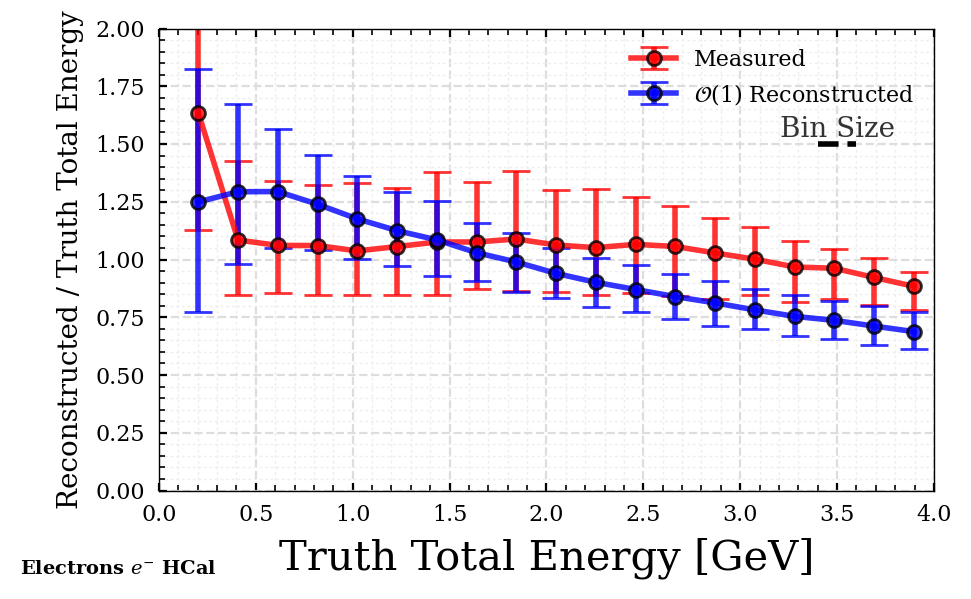

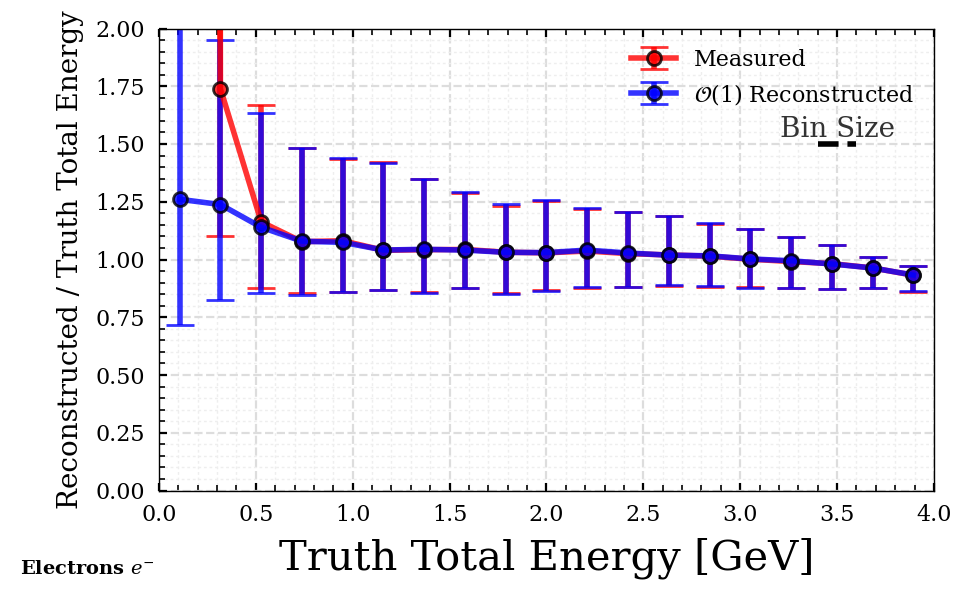

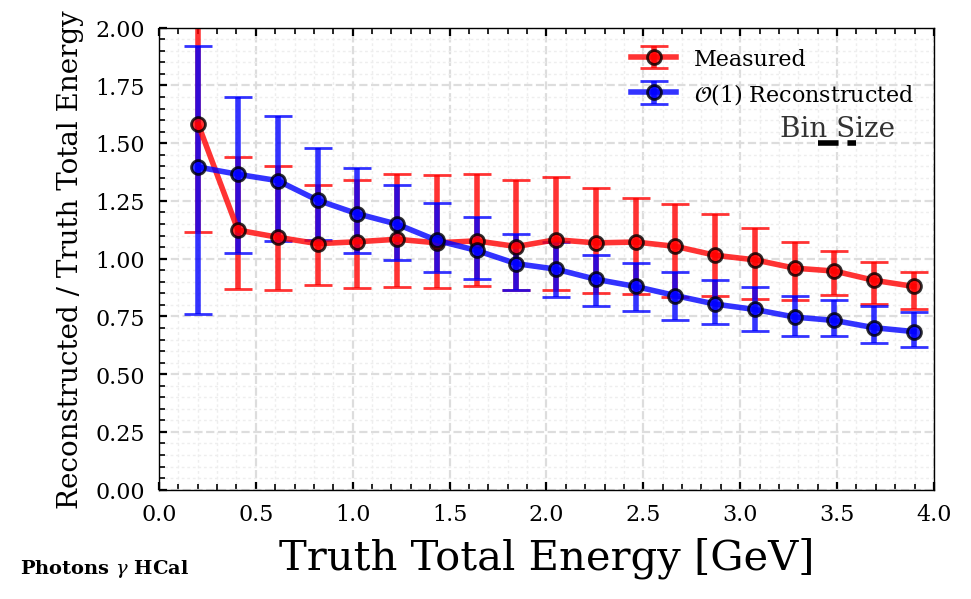

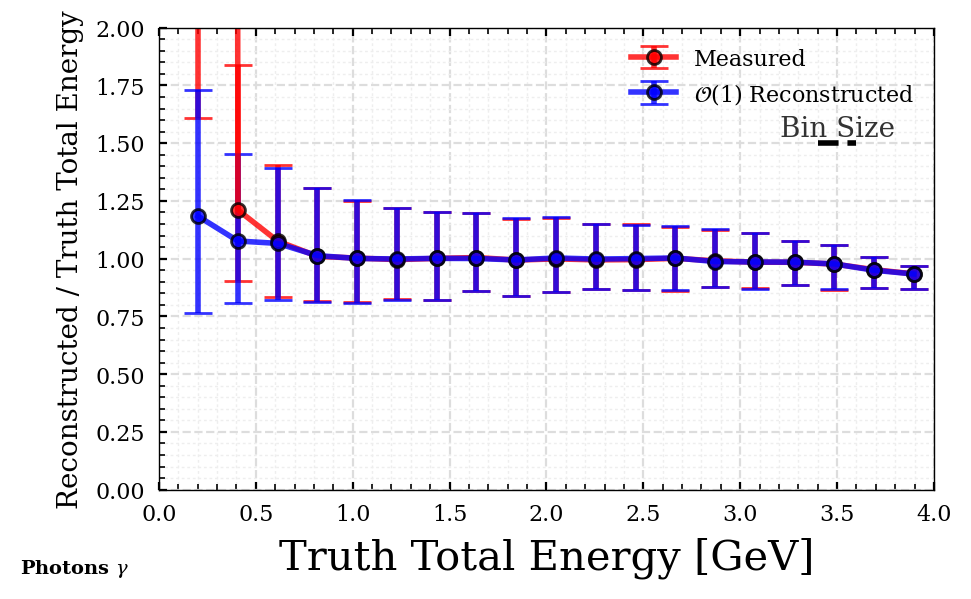

In [23]:
electrons_hcal.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                             energy_bins_hcal=ext_bins_hcal, o1corr_hcal=pe_o1corr_hcal,
                             scheme=scheme, label=labels_dict['electrons_hcal'])
electrons.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                        energy_bins_hcal=ext_bins_hcal, o1corr_hcal=pe_o1corr_hcal,
                        scheme=scheme, label=labels_dict['electrons'])
photons_hcal.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                           energy_bins_hcal=ext_bins_hcal, o1corr_hcal=pe_o1corr_hcal,
                           scheme=scheme, label=labels_dict['photons_hcal'])
photons.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                      energy_bins_hcal=ext_bins_hcal, o1corr_hcal=pe_o1corr_hcal,
                      scheme=scheme, label=labels_dict['photons'])

Other particles

HCal energy set to truth
(9999,) (9999,)
(9999,) (9999,)
(19,) (19,) (19,)
(9999,) (9999,)
(9999,) (9999,)
(19,) (19,) (19,)
Target energy set to truth
(9981,) (9981,)
(9981,) (9981,)
(19,) (19,) (19,)
(9981,) (9981,)
(9981,) (9981,)
(19,) (19,) (19,)
HCal energy set to truth
(9999,) (9999,)
(9999,) (9999,)
(19,) (19,) (19,)
(9999,) (9999,)
(9999,) (9999,)
(19,) (19,) (19,)
Target energy set to truth
(9986,) (9986,)
(9986,) (9986,)
(19,) (19,) (19,)
(9986,) (9986,)
(9986,) (9986,)
(19,) (19,) (19,)
HCal energy set to truth
(10000,) (10000,)
(10000,) (10000,)
(19,) (19,) (19,)
(10000,) (10000,)
(10000,) (10000,)
(19,) (19,) (19,)
Target energy set to truth
(9978,) (9978,)
(9978,) (9978,)
(19,) (19,) (19,)
(9978,) (9978,)
(9978,) (9978,)
(19,) (19,) (19,)


(array([ 953.31775254, 2274.83179462, 2216.95842365, ..., 1198.10623166,
         781.19022059,  404.31142921]),
 array([1.29847351e+00, 7.19999422e+02, 3.86761730e+01, ...,
        0.00000000e+00, 0.00000000e+00, 1.48179230e+03]),
 array([ 954.61622606, 2994.83121629, 2255.63459668, ..., 1198.10623166,
         781.19022059, 1886.10372716]))

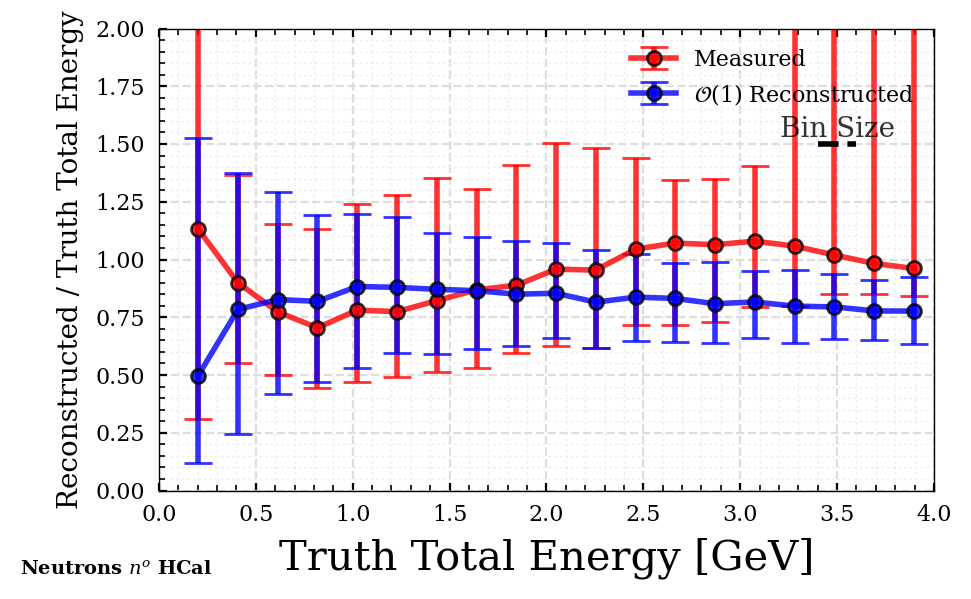

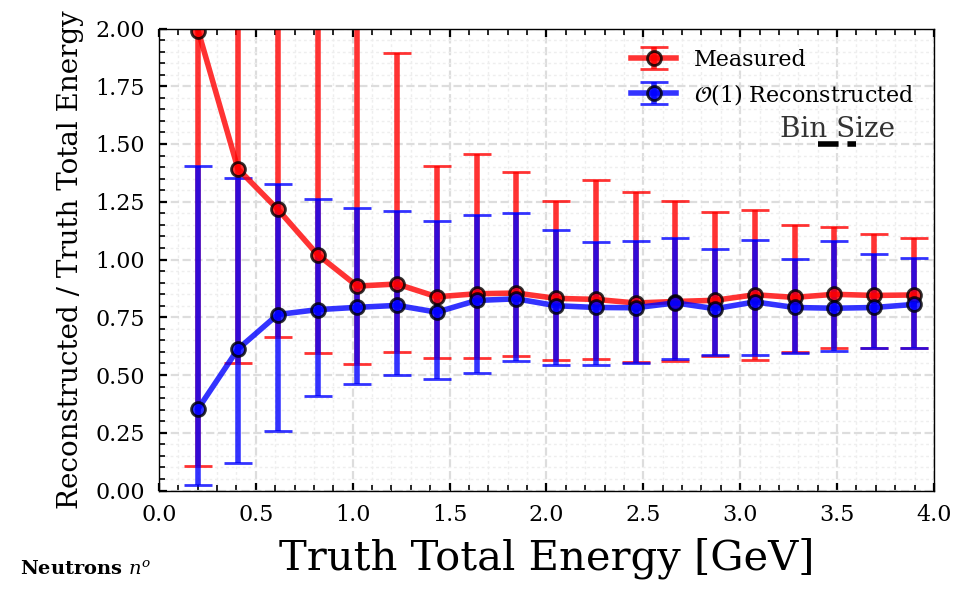

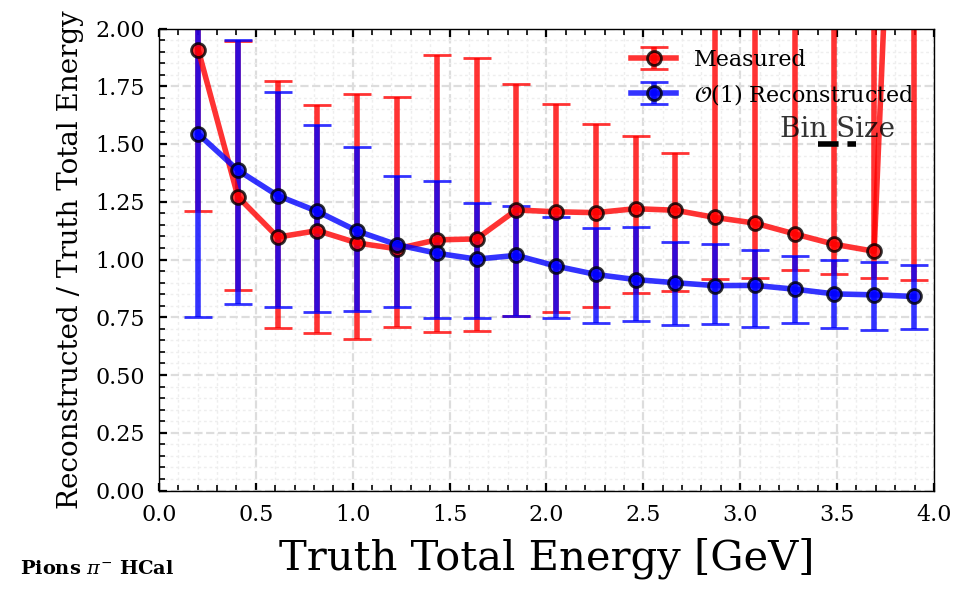

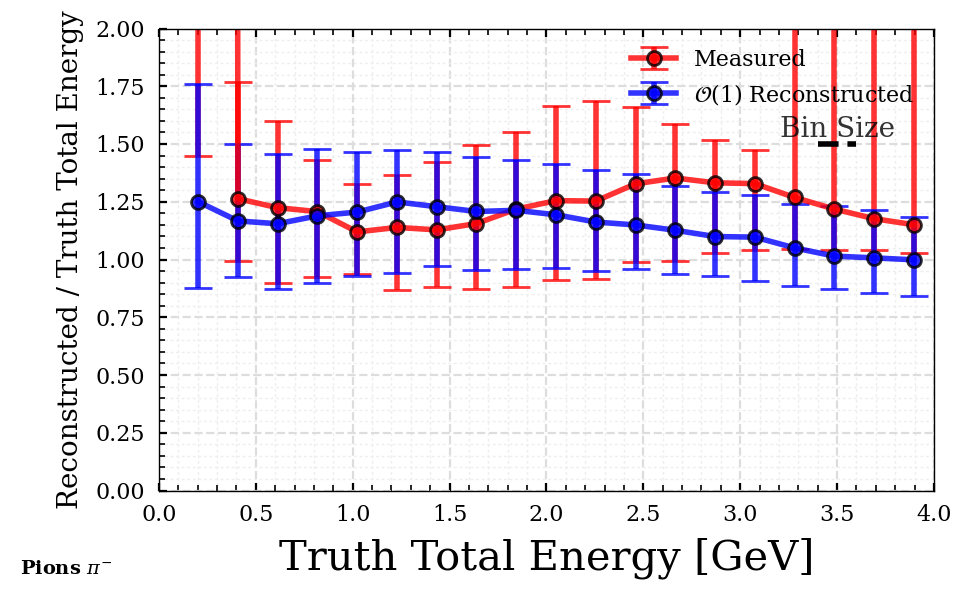

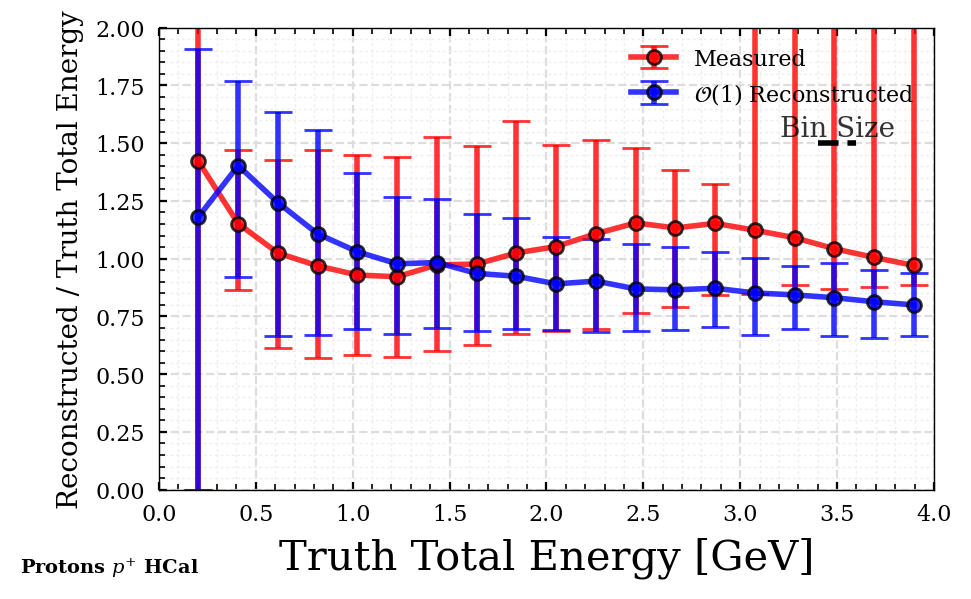

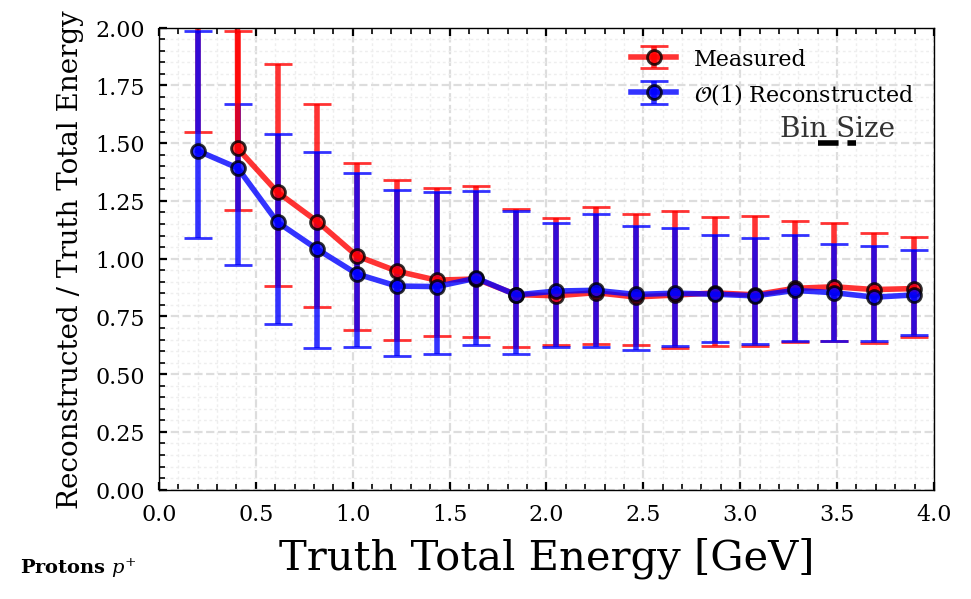

In [24]:
neutrons_hcal.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                            energy_bins_hcal=ext_bins_hcal, o1corr_hcal=pe_o1corr_hcal,
                            scheme=scheme, label=labels_dict['neutrons_hcal'])
neutrons.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                       energy_bins_hcal=ext_bins_hcal, o1corr_hcal=pe_o1corr_hcal,
                       scheme=scheme, label=labels_dict['neutrons'])
pions_hcal.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                         energy_bins_hcal=ext_bins_hcal, o1corr_hcal=pe_o1corr_hcal,
                         scheme=scheme, label=labels_dict['pions_hcal'])
pions.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                    energy_bins_hcal=ext_bins_hcal, o1corr_hcal=pe_o1corr_hcal,
                    scheme=scheme, label=labels_dict['pions'])
protons_hcal.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                           energy_bins_hcal=ext_bins_hcal, o1corr_hcal=pe_o1corr_hcal,
                           scheme=scheme, label=labels_dict['protons_hcal'])
protons.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                      energy_bins_hcal=ext_bins_hcal, o1corr_hcal=pe_o1corr_hcal,
                      scheme=scheme, label=labels_dict['protons'])

# Spatial Resolution

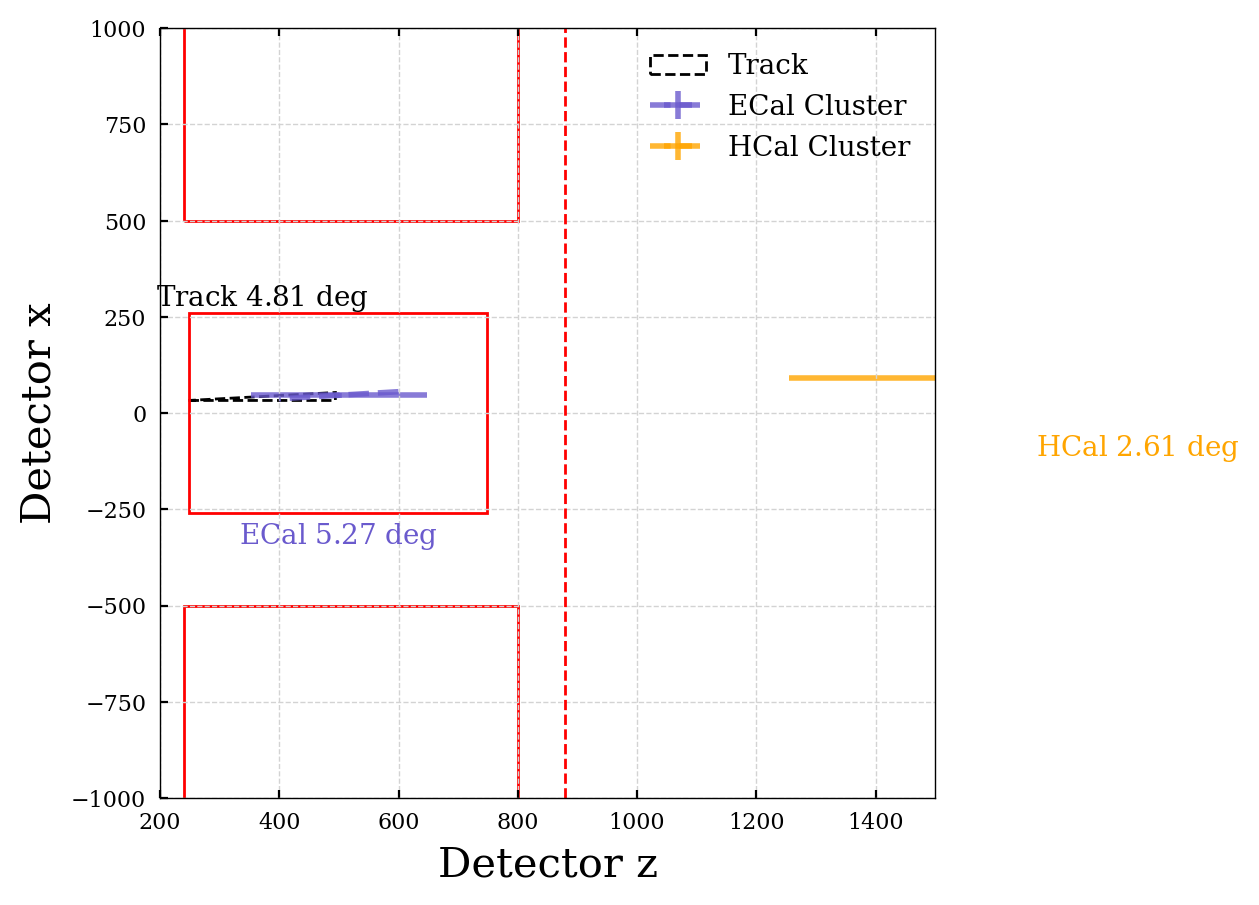

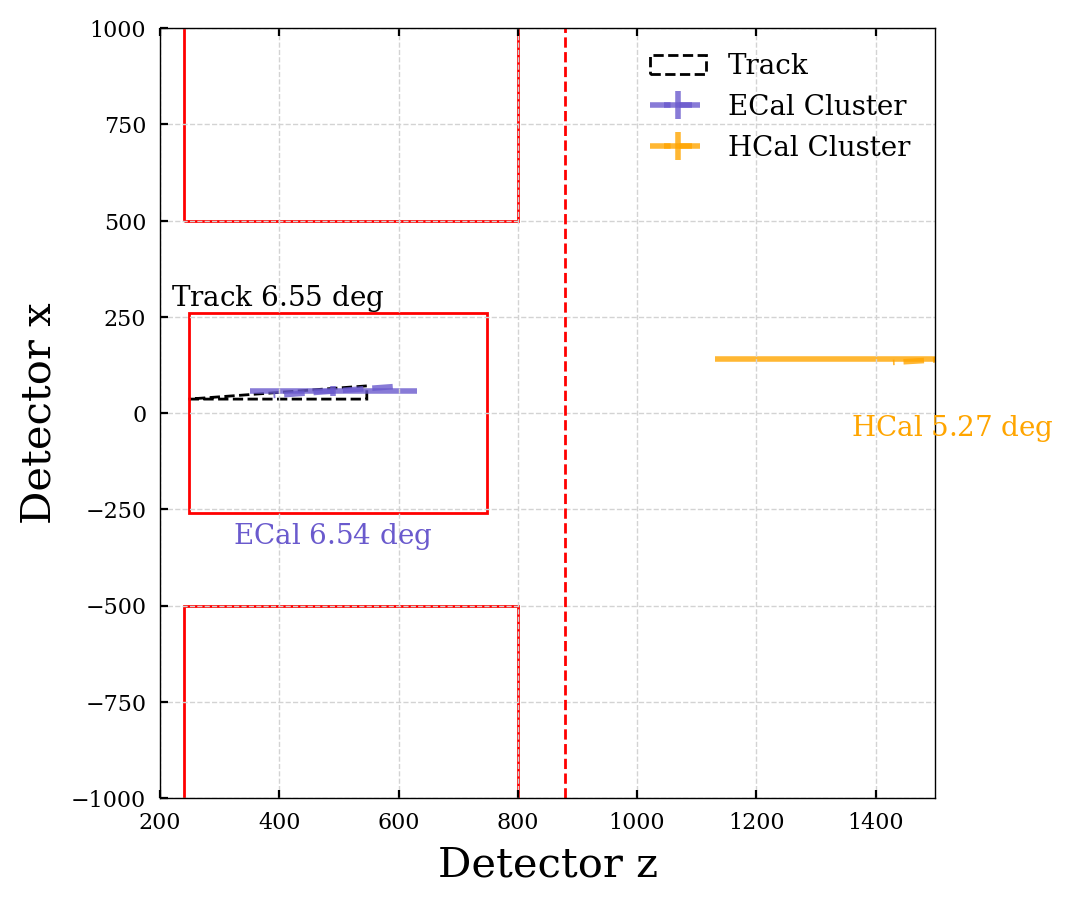

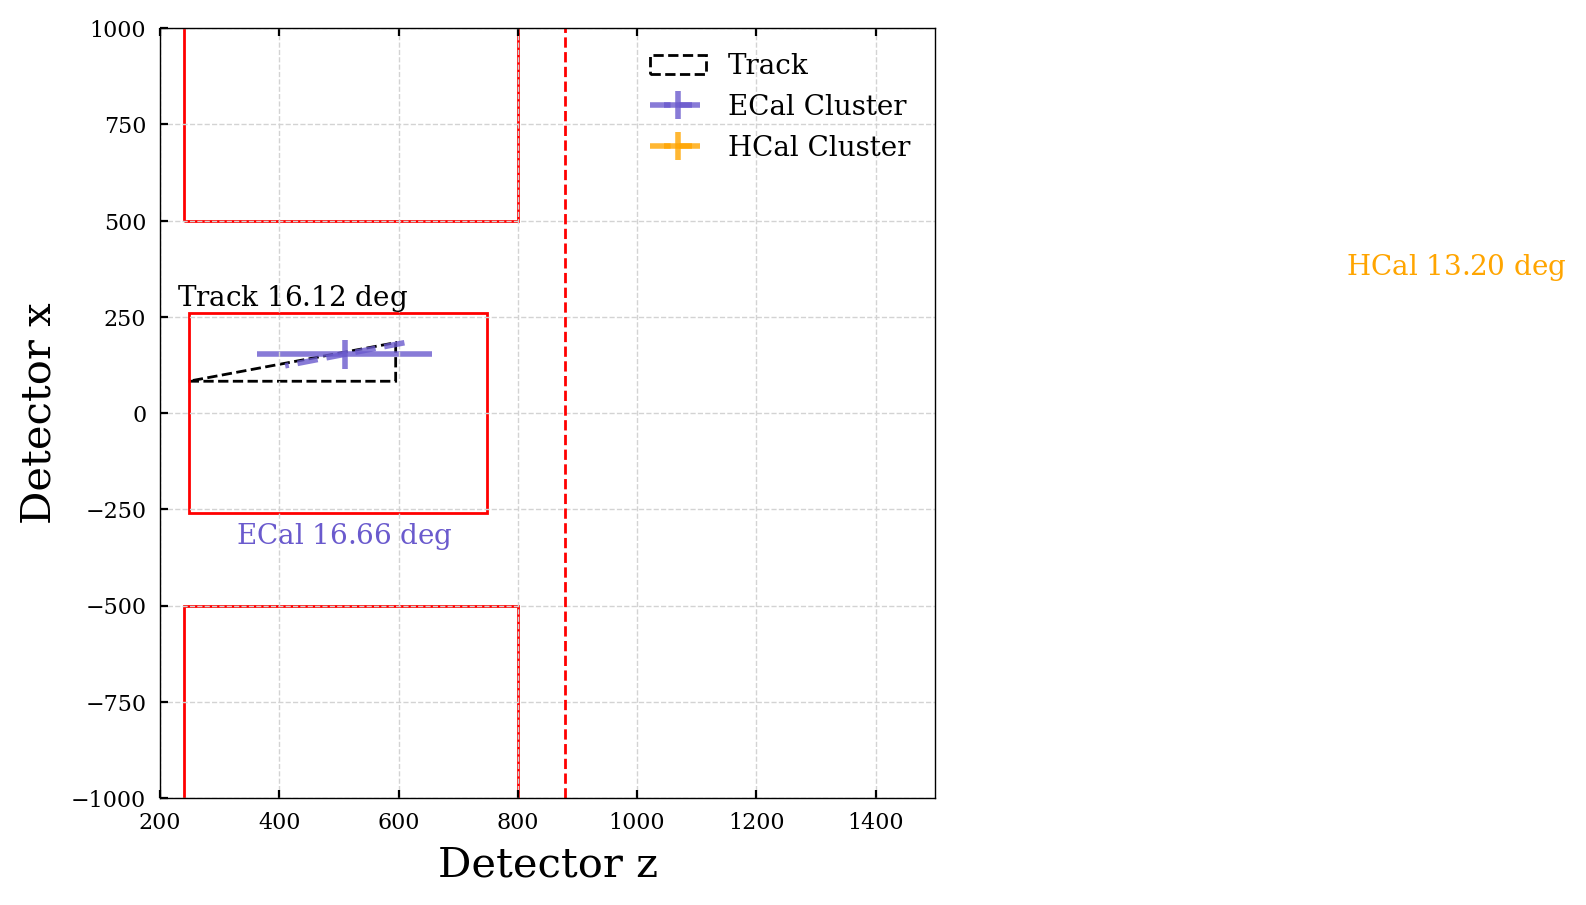

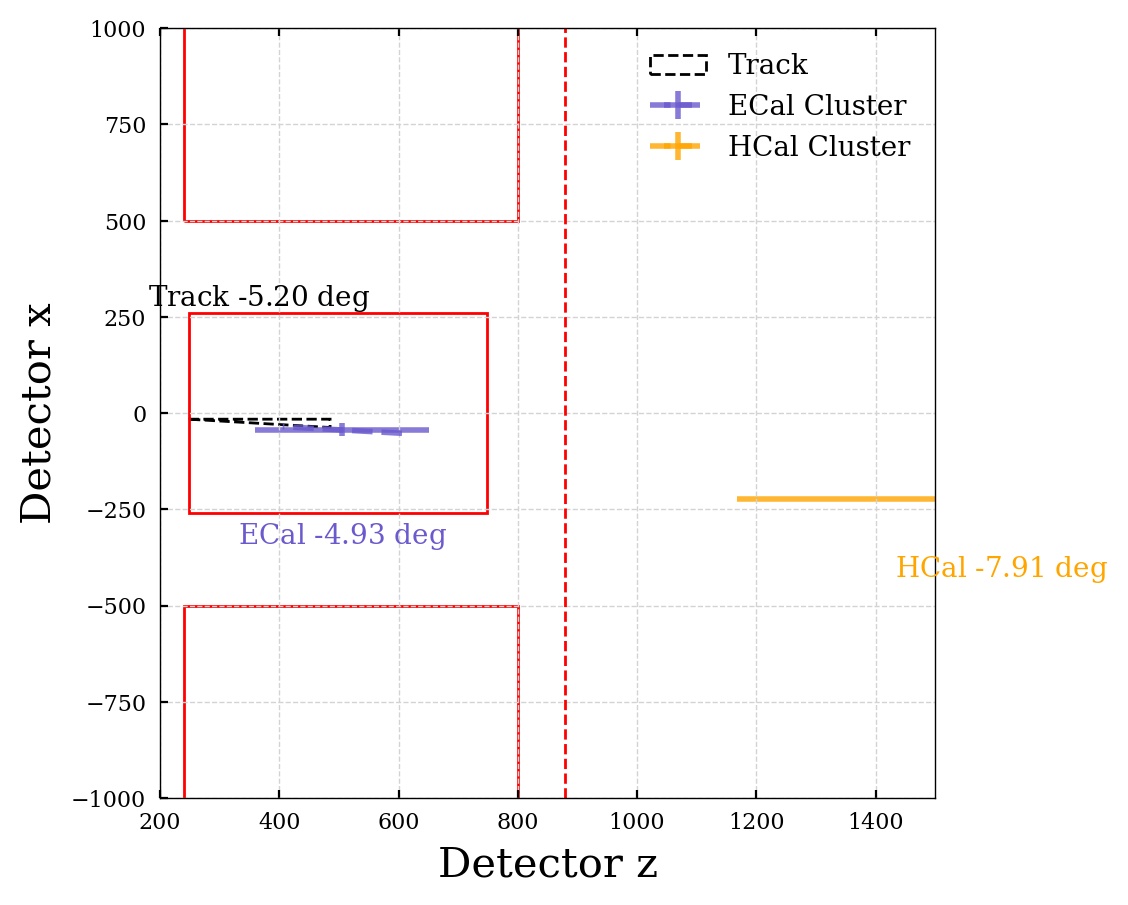

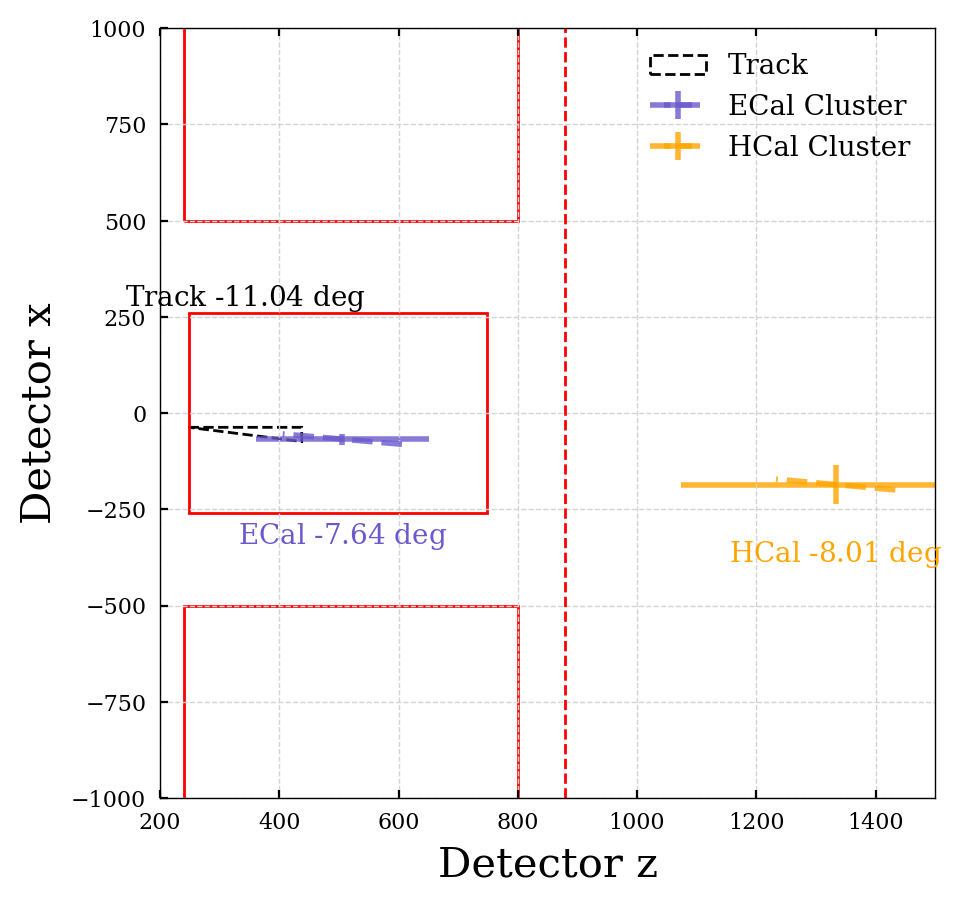

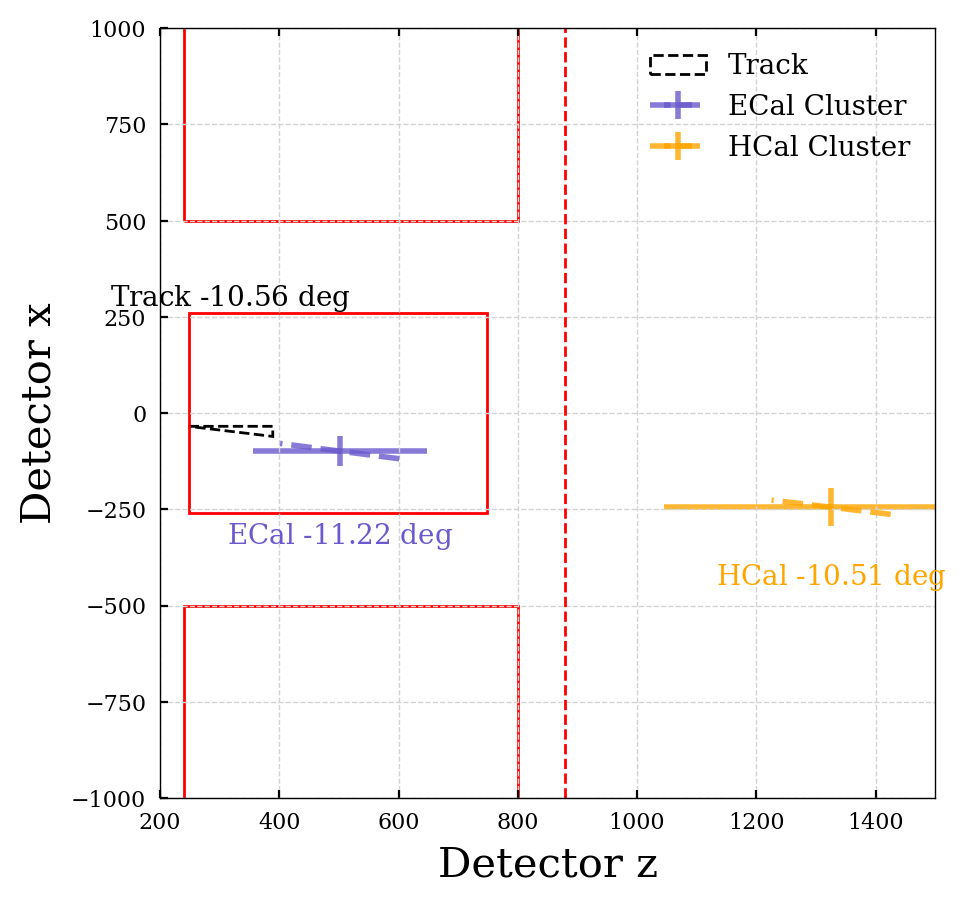

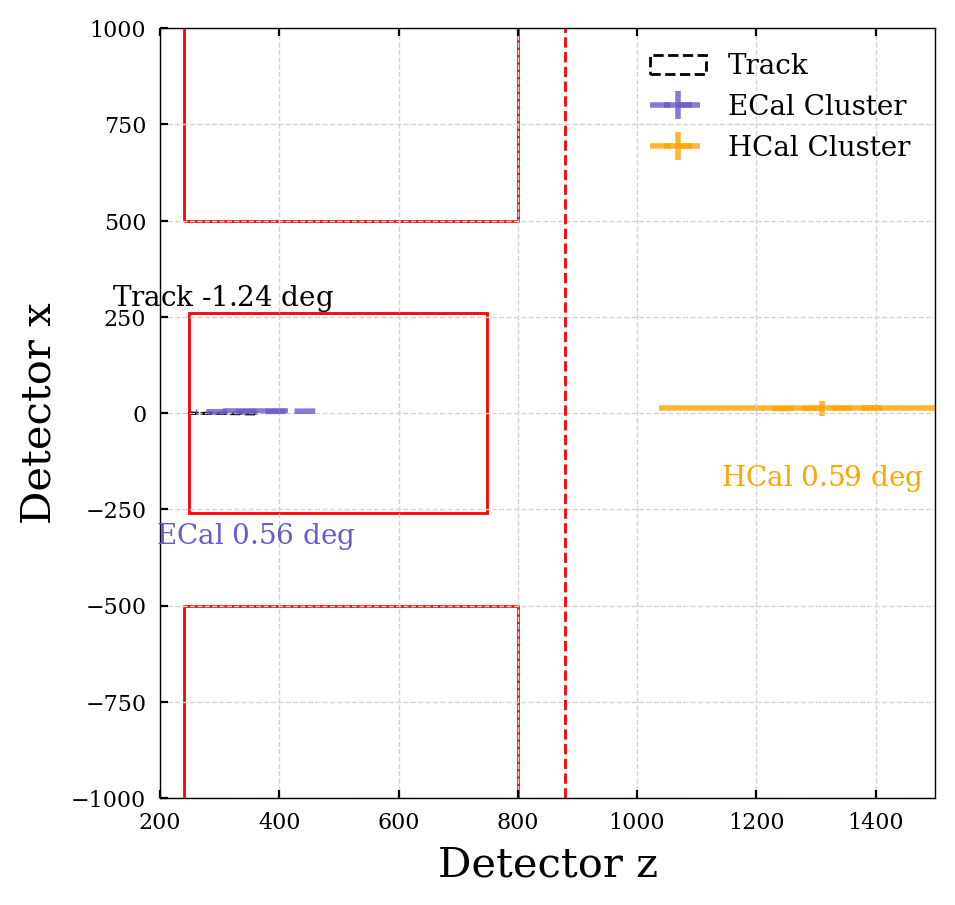

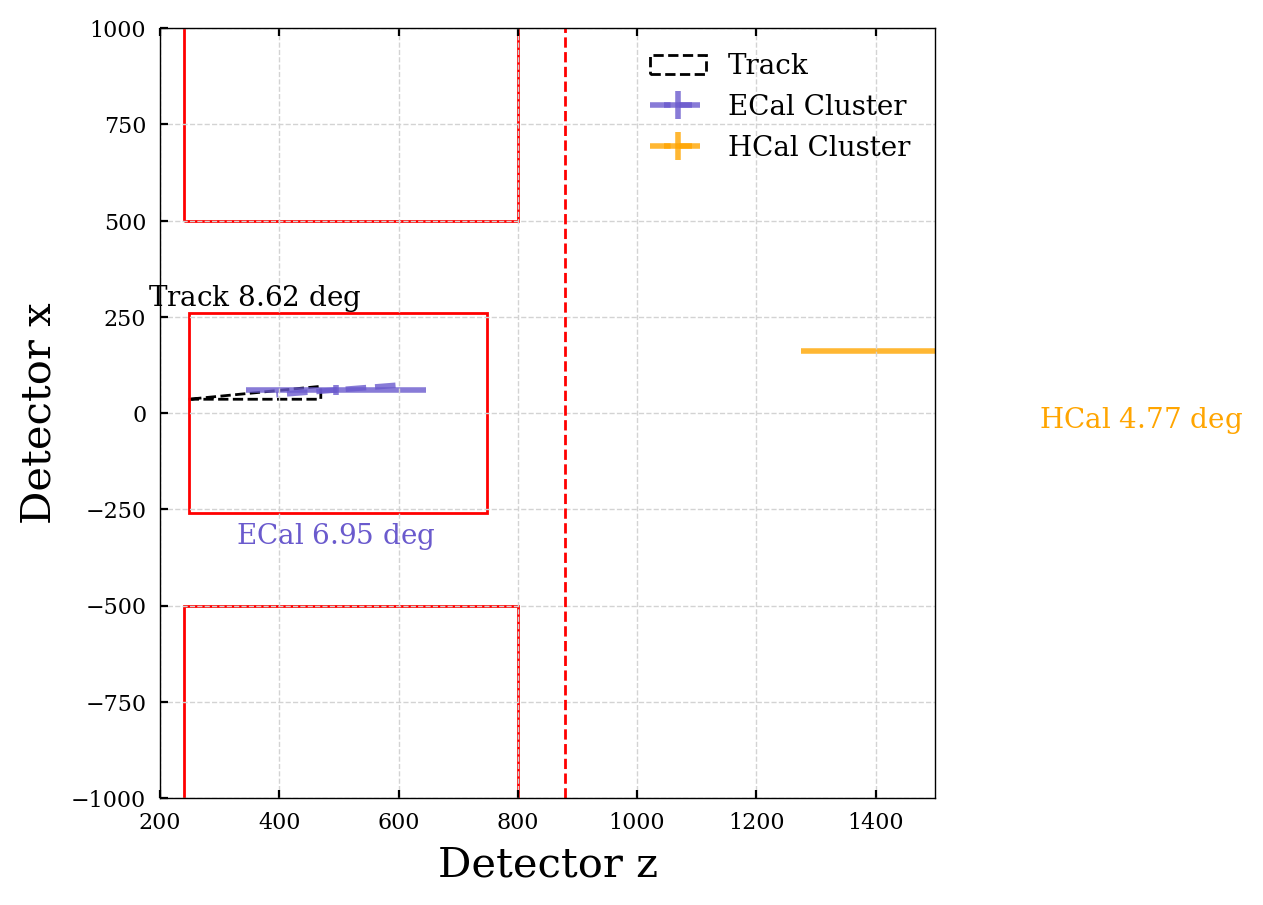

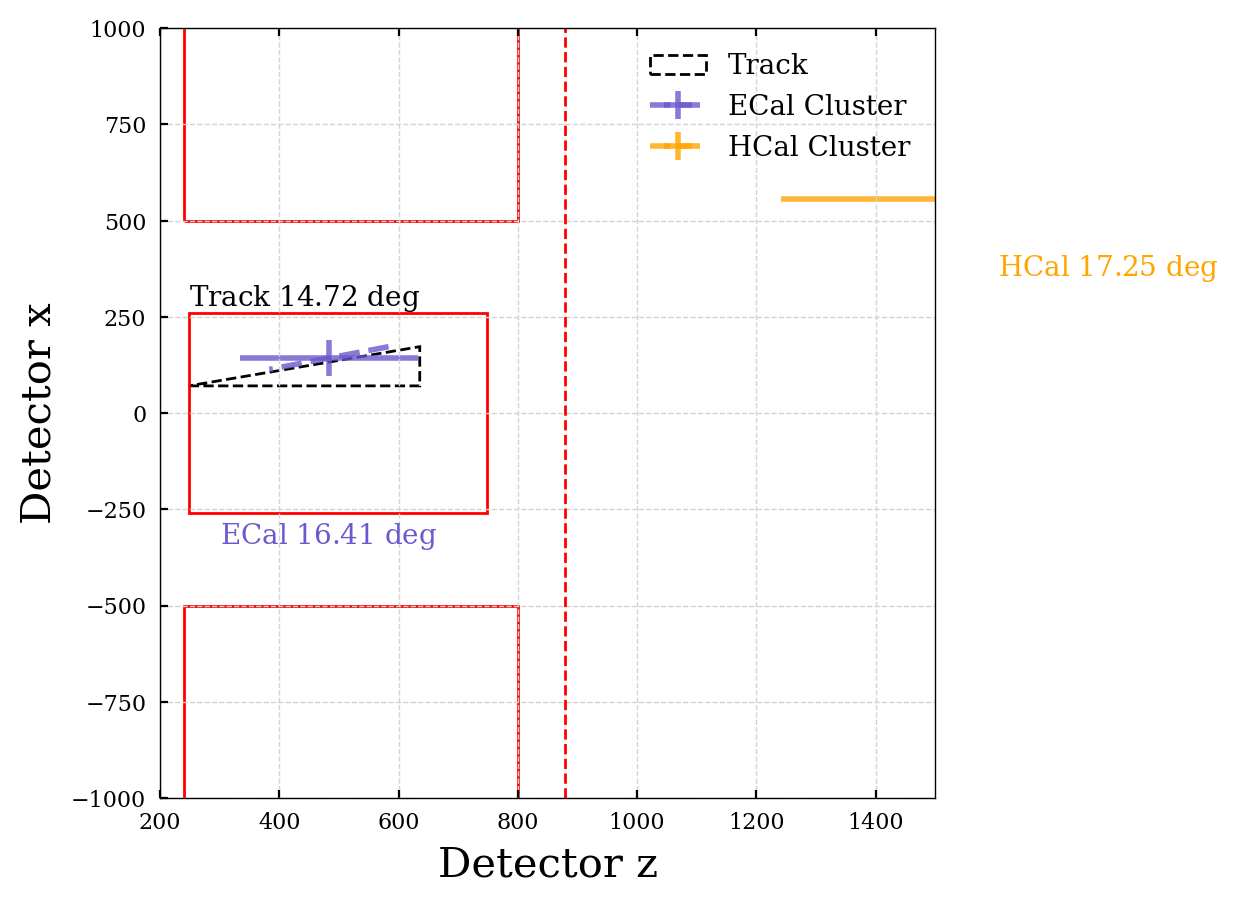

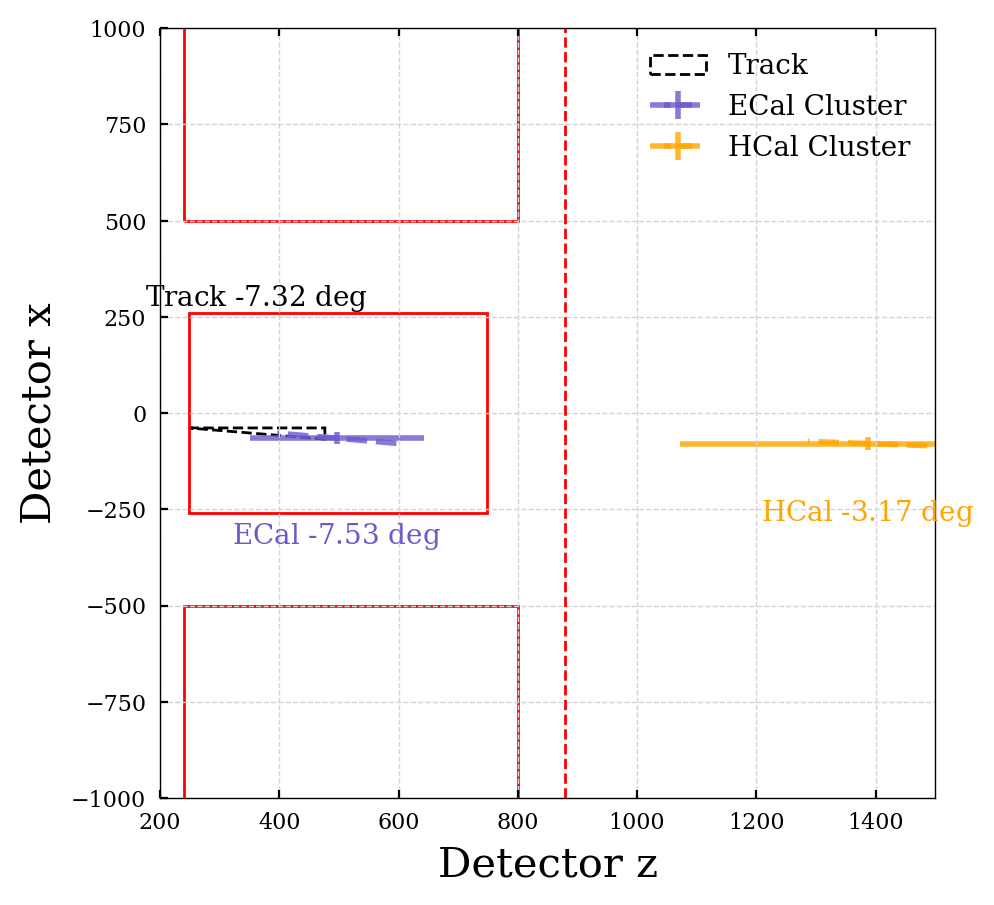

In [28]:
# global variables
ECALZ_MIN = 247.9
ECALZ_MAX = 749.1
ECALW = 520

BHCALZ_MIN = 879
SHCALZ_MIN = 240
SHCALZ_MAX = 800
SHCALX_MIN = 500
SHCALX_MAX = 1500

# the style used for the confidence range plots
# 0: area
# 1: error bars
style = 1

def plot_ecal_box(ax, label=False):
    box_label = 'ECal' if label else ''
    ax.add_patch(plt.Rectangle((ECALZ_MIN, -ECALW/2), ECALZ_MAX - ECALZ_MIN, ECALW, fc=(0, 0, 0, 0), ec='red', label=box_label))
    
def plot_hcal_box(ax, label=False):
    box_label = 'HCal' if label else ''
    ax.add_patch(plt.Rectangle((SHCALZ_MIN, SHCALX_MIN), SHCALZ_MAX - SHCALZ_MIN, SHCALX_MAX - SHCALX_MIN, fc=(0, 0, 0, 0), ec='red', label=box_label))
    ax.add_patch(plt.Rectangle((SHCALZ_MIN, -SHCALX_MAX), SHCALZ_MAX - SHCALZ_MIN, SHCALX_MAX - SHCALX_MIN, fc=(0, 0, 0, 0), ec='red', label=box_label))
    ax.axvline(x=BHCALZ_MIN, lw=1, ls='--', color='red', label=box_label)



from matplotlib.patches import Polygon

def plot_cluster_dist(particles, i=0, factor=10, length=100, extend=False,
                      track_color = 'black', ecal_color = 'slateblue', hcal_color = 'orange'):
    track_Pz = particles.get('PFCandidates_trackPz')
    track_Px = particles.get('PFCandidates_trackPx')
    track_posX = particles.get('PFCandidates_posEcalX')
    ecal_clusterZ = particles.get('PFCandidates_ecalClusterZ')
    ecal_clusterX = particles.get('PFCandidates_ecalClusterX')
    ecal_clusterEZ = particles.get('PFCandidates_ecalClusterEZ')
    ecal_clusterEX = particles.get('PFCandidates_ecalClusterEX')
    ecal_clusterDXDZ = particles.get('PFCandidates_ecalClusterDXDZ')
    hcal_clusterZ = particles.get('PFCandidates_hcalClusterZ')
    hcal_clusterX = particles.get('PFCandidates_hcalClusterX')
    hcal_clusterEZ = particles.get('PFCandidates_hcalClusterEZ')
    hcal_clusterEX = particles.get('PFCandidates_hcalClusterEX')
    hcal_clusterDXDZ = particles.get('PFCandidates_hcalClusterDXDZ')
    
    # setting up plot
    fig, ax = plt.subplots(figsize=(5, 5), dpi=200)
    
    """Track Momentum"""
    # add triangle
    Pz = track_Pz[i]/factor
    Px = track_Px[i]/factor
    xy = [[ECALZ_MIN, track_posX[i]], [ECALZ_MIN+Pz, track_posX[i]], [ECALZ_MIN+Pz, track_posX[i]+Px]]
    momentum = Polygon(xy=xy, fc='None', ec=track_color, ls='--', label='Track')
    ax.add_patch(momentum)
    # add annotation
    track_angle = np.rad2deg(np.arctan(Px/Pz))
    ax.text(ECALZ_MIN+Pz/2, ECALW/2+20, fr'Track {track_angle:.2f} $\deg$', color=track_color, ha='center')
    # extend
    if extend:
        ax.axline(xy1=[ECALZ_MIN, track_posX[i]], xy2=[ECALZ_MIN + Pz * 10, track_posX[i] + Px * 10], lw=1, ls='--', alpha=0.5, color=track_color)
    
    """Ecal Box"""
    ecal_z = ecal_clusterZ[i]
    ecal_x = ecal_clusterX[i]
    ecal_ez = ecal_clusterEZ[i]
    ecal_ex = ecal_clusterEX[i]
    plotting.error_bar(fig, ax, x=ecal_z, y=ecal_x, xerr=[[ecal_ez], [ecal_ez]], yerr=[[ecal_ex], [ecal_ex]], color=ecal_color, fmt='--', label='ECal Cluster')
    # the angle
    ecal_tan = ecal_clusterDXDZ[i]
    ecal_angle = np.rad2deg(np.arctan(ecal_tan))
    ax.plot([ecal_z+length, ecal_z-length], [ecal_x+length*ecal_tan, ecal_x-length*ecal_tan], color=ecal_color, ls='--', alpha=0.8)
    ax.text(ecal_z, -ECALW/2-80, fr'ECal {ecal_angle:.2f} $\deg$', color=ecal_color, ha='center')
    # extend
    if extend:
        ax.axline(xy1=[ecal_z, ecal_x], xy2=[ecal_z + length * 10, ecal_x + length * 10 * ecal_tan], lw=1, ls='--', alpha=0.5, color=ecal_color)
    
    """Hcal Box"""
    hcal_z = hcal_clusterZ[i]
    hcal_x = hcal_clusterX[i]
    hcal_ez = hcal_clusterEZ[i]
    hcal_ex = hcal_clusterEX[i]
    plotting.error_bar(fig, ax, x=hcal_z, y=hcal_x, xerr=[[hcal_ez], [hcal_ez]], yerr=[[hcal_ex], [hcal_ex]], color=hcal_color, fmt='--', label='HCal Cluster')
    # the angle
    hcal_tan = hcal_clusterDXDZ[i]
    hcal_angle = np.rad2deg(np.arctan(hcal_tan))
    ax.plot([hcal_z+length, hcal_z-length], [hcal_x+length*hcal_tan, hcal_x-length*hcal_tan], color=hcal_color, ls='--', alpha=0.8)
    ax.text(hcal_z, hcal_x-length*2, fr'HCal {hcal_angle:.2f} $\deg$', color=hcal_color, ha='center')
    # extend
    if extend:
        ax.axline(xy1=[hcal_z, hcal_x], xy2=[hcal_z + length * 10, hcal_x + length * 10 * hcal_tan], lw=1, ls='--', alpha=0.5, color=hcal_color)
    
    # axis
    ax.set_xlabel('Detector z')
    ax.set_ylabel('Detector x')
    ax.set_xlim(200, 1500)
    ax.set_ylim(-1000, 1000)

    # # particle and energy
    # measure_ecal_energy = particles.get("PFCandidates_ecalEnergy")[i]
    # measure_hcal_energy = particles.get("PFCandidates_hcalEnergy")[i]
    # recon_ecal_energy = particles.get("PFCandidates_ecalEnergy_o1corr")[i]
    # recon_hcal_energy = particles.get("PFCandidates_hcalEnergy_o1corr")[i]
    # truth_ecal_energy = particles.get("PFTruthEcal_energy")[i]
    # truth_hcal_energy = particles.get("PFTruthHcal_energy")[i]
    # energy_text_x = 1490
    # # ax.text(energy_text_x, -450, f'Ecal {measure_ecal_energy:.2f} MeV', ha='right')
    # # ax.text(energy_text_x, -550, f'Hcal {measure_hcal_energy:.2f} MeV', ha='right')
    # ax.text(energy_text_x, -650, f'Ecal Recon {recon_ecal_energy:.2f} MeV', ha='right')
    # ax.text(energy_text_x, -750, f'Hcal Recon {recon_hcal_energy:.2f} MeV', ha='right')
    # ax.text(energy_text_x, -850, f'Ecal Truth {truth_ecal_energy:.2f} MeV', ha='right')
    # ax.text(energy_text_x, -950, f'Hcal Truth {truth_hcal_energy:.2f} MeV', ha='right')
    
    # boxes
    plot_ecal_box(ax, 0)
    plot_hcal_box(ax, 0)
    plt.legend(fontsize=10)
    plt.show()

for i in range(10):
    plot_cluster_dist(pions, i)



import pickle
uw_hcal_particles_dict = {
    'electrons_hcal': None,
    'photons_hcal': None,
    'neutrons_hcal': None,
    'pions_hcal': None,
    'protons_hcal': None
}
uw_both_particles_dict = {
    'electrons': None,
    'photons': None,
    'neutrons': None,
    'pions': None,
    'protons': None
}
for file_name in uw_hcal_particles_dict.keys():
    with open(f"data/pickles/{file_name}.pkl", 'rb') as handle:
        data = handle.read()
    uw_hcal_particles_dict[file_name] = pickle.loads(data)
for file_name in uw_both_particles_dict.keys():
    with open(f"data/pickles/{file_name}.pkl", 'rb') as handle:
        data = handle.read()
    uw_both_particles_dict[file_name] = pickle.loads(data)

## ECal Resolution

In [25]:
def plot_clust_resolution_ecal(fig, ax, particles_name, xy='x', marker='+', color='slateblue', binwidth=200, size=50, erg_max=5e3, alpha=1, label=True):
    import scipy.stats as stats

    """Grab the Numbers"""
    particles = both_particles_dict[particles_name]
    # set the reconstructed energy
    erg_recon = particles.get('PFCandidates_ecalEnergy_o1corr')
    # ratio of cluster resolution
    """Switch"""
    if xy in ['y', 'Y']:
        track_Px = particles.get('PFCandidates_trackPy')
        track_posX = particles.get('PFCandidates_posEcalY')
        ecal_clusterX = particles.get('PFCandidates_ecalClusterY')
        ecal_clusterEX = particles.get('PFCandidates_ecalClusterEY')
        ecal_clusterDXDZ = particles.get('PFCandidates_ecalClusterDYDZ')
    else:
        track_Px = particles.get('PFCandidates_trackPx')
        track_posX = particles.get('PFCandidates_posEcalX')
        ecal_clusterX = particles.get('PFCandidates_ecalClusterX')
        ecal_clusterEX = particles.get('PFCandidates_ecalClusterEX')
        ecal_clusterDXDZ = particles.get('PFCandidates_ecalClusterDXDZ')
    ecal_clusterZ = particles.get('PFCandidates_ecalClusterZ')
    track_Pz = particles.get('PFCandidates_trackPz')
    ecal_clusterZ = particles.get('PFCandidates_ecalClusterZ')
    ecal_clusterEZ = particles.get('PFCandidates_ecalClusterEZ')

    # track angle
    track_tan = track_Px/track_Pz
    track_angle = np.rad2deg(np.arctan(track_tan))
    
    # ecal angle
    ecal_tan = ecal_clusterDXDZ
    ecal_angle = np.rad2deg(np.arctan(ecal_tan))
    proj_distZ = ecal_clusterZ - ECALZ_MIN
    proj_distX = proj_distZ * track_tan
    proj_ecalX = track_posX + proj_distX  # the projected x position on ecal plane
    proj_EX = ecal_clusterX - proj_ecalX  # difference between projected and cluster position
    # the number for each bin
    proj_rms = proj_EX/ecal_clusterEX

    """Bin"""
    # filter outliers
    proj_rms, erg_recon = plotting._clean_data(proj_rms, erg_recon)

    X = erg_recon
    Y = proj_rms
    # get bins
    XY_bins = np.arange(start=0, stop=erg_max, step=binwidth) # bins, including last element
    XY_bins = np.append(XY_bins, XY_bins[-1] + binwidth)
    
    # define percentile functions
    def _16(arr): return np.quantile(arr, .159) # sigma CI
    def _84(arr): return np.quantile(arr, .841)
    def _05(arr): return np.quantile(arr, .025) # 95%, close to 2 sigma CI
    def _95(arr): return np.quantile(arr, .975)
    XY_med = stats.binned_statistic(X, Y, statistic=np.median, bins=XY_bins)[0] # median
    XY_16 = stats.binned_statistic(X, Y, statistic=_16, bins=XY_bins)[0] # percentiles
    XY_84 = stats.binned_statistic(X, Y, statistic=_84, bins=XY_bins)[0]
    XY_05 = stats.binned_statistic(X, Y, statistic=_05, bins=XY_bins)[0]
    XY_95 = stats.binned_statistic(X, Y, statistic=_95, bins=XY_bins)[0]
    XY_bins_avg = [(a + b) / 2 for a, b in zip(XY_bins[::], XY_bins[1::])] # average of two consecutive elements in bins

    part_label = labels_dict[particles_name] if label else ''
    plotting.scatter(fig, ax, XY_bins_avg, (XY_84 - XY_16)/2, s=40, lw=2, c=color, a=alpha, label=part_label, xlabel='Energy Bins', ylabel=r'Projection / Cluster $\sigma$')

full_particles_list = [
    'electrons',
    'photons',
    'neutrons',
    'pions',
    'protons'
]

def plot_clust_resolution_ecal_others(fig, ax, particles_list, xy='x', binwidth=200, erg_max=5e3):
    other_particles_list = []
    for particles in full_particles_list:
        # add every particle not in the list to plot
        if particles not in particles_list:
            other_particles_list.append(particles)
    
    # all other particles
    for particles in other_particles_list:
        plot_clust_resolution_ecal(fig, ax, particles, xy=xy, binwidth=binwidth, erg_max=5e3, color='gray', alpha=0.3, label=False)

In [26]:
binwidth = 200
xy = 'y'

### Electrons

Axes limits [100.0, 3900.0] and [0.11346641065201953, 0.595445083187459]
Axes limits [100.0, 3900.0] and [0.14624966676877327, 0.679954075704583]
Axes limits [100.0, 4900.0] and [0.0, 3.122701131404127]
Axes limits [100.0, 4500.0] and [0.0, 1.2017300406340012]
Axes limits [100.0, 4700.0] and [0.0, 0.5638871533114381]


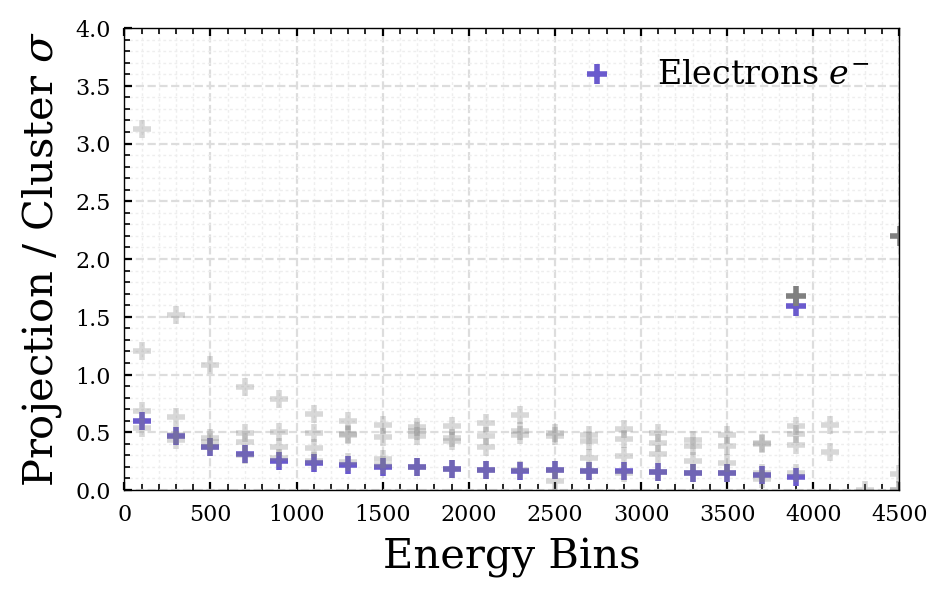

In [29]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = ['electrons']
plot_clust_resolution_ecal(fig, ax, 'electrons', xy, binwidth=binwidth, erg_max=5e3)
plot_clust_resolution_ecal_others(fig, ax, part_particles_list, xy, binwidth=binwidth, erg_max=5e3)
ax.set_xlim(0, 4.5e3)
ax.set_ylim(0, 4)
ax.legend(fontsize=12)
plt.show()

### Photons

Axes limits [100.0, 3900.0] and [0.14624966676877327, 0.679954075704583]
Axes limits [100.0, 3900.0] and [0.11346641065201953, 0.595445083187459]
Axes limits [100.0, 4900.0] and [0.0, 3.122701131404127]
Axes limits [100.0, 4500.0] and [0.0, 1.2017300406340012]
Axes limits [100.0, 4700.0] and [0.0, 0.5638871533114381]


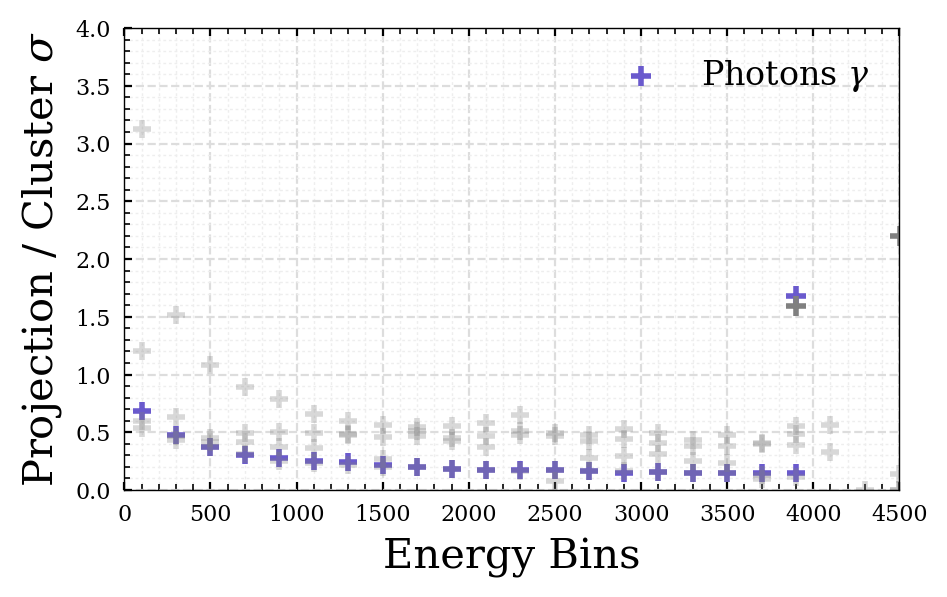

In [30]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = ['photons']
plot_clust_resolution_ecal(fig, ax, 'photons', xy, binwidth=binwidth, erg_max=5e3)
plot_clust_resolution_ecal_others(fig, ax, part_particles_list, xy, binwidth=binwidth, erg_max=5e3)
ax.set_xlim(0, 4.5e3)
ax.set_ylim(0, 4)
ax.legend(fontsize=12)
plt.show()

### Pions

Axes limits [100.0, 4500.0] and [0.0, 1.2017300406340012]
Axes limits [100.0, 3900.0] and [0.11346641065201953, 0.595445083187459]
Axes limits [100.0, 3900.0] and [0.14624966676877327, 0.679954075704583]
Axes limits [100.0, 4900.0] and [0.0, 3.122701131404127]
Axes limits [100.0, 4700.0] and [0.0, 0.5638871533114381]


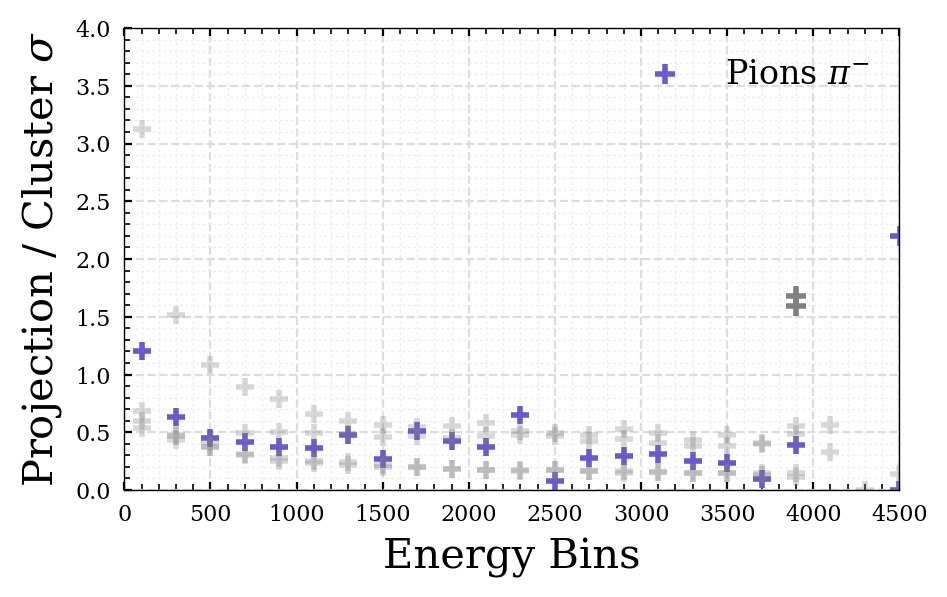

In [31]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = ['pions']
plot_clust_resolution_ecal(fig, ax, 'pions', xy, binwidth=binwidth, erg_max=5e3)
plot_clust_resolution_ecal_others(fig, ax, part_particles_list, xy, binwidth=binwidth, erg_max=5e3)
ax.set_xlim(0, 4.5e3)
ax.set_ylim(0, 4)
ax.legend(fontsize=12)
plt.show()

### Protons

Axes limits [100.0, 4700.0] and [0.0, 0.5638871533114381]
Axes limits [100.0, 3900.0] and [0.11346641065201953, 0.595445083187459]
Axes limits [100.0, 3900.0] and [0.14624966676877327, 0.679954075704583]
Axes limits [100.0, 4900.0] and [0.0, 3.122701131404127]
Axes limits [100.0, 4500.0] and [0.0, 1.2017300406340012]


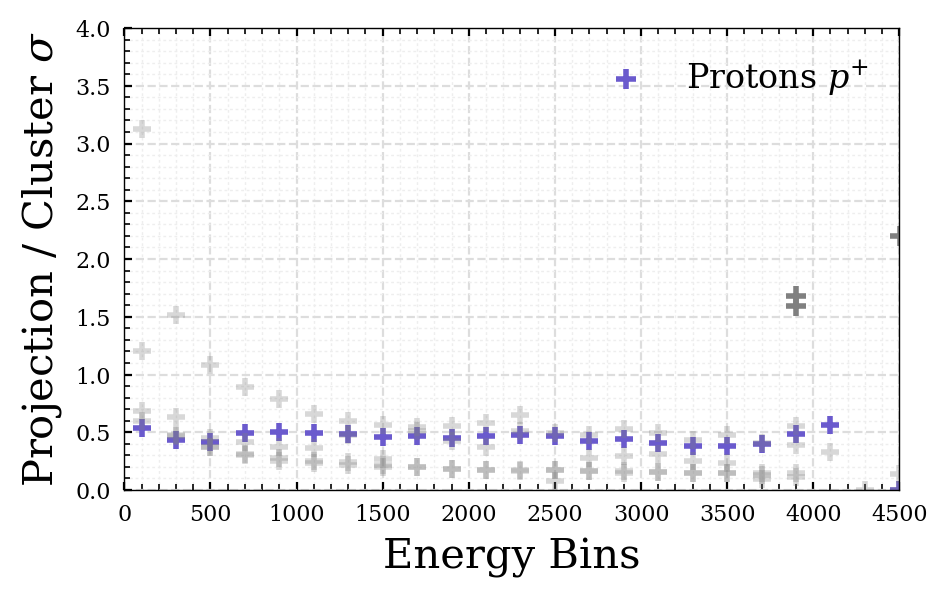

In [32]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = ['protons']
plot_clust_resolution_ecal(fig, ax, 'protons', xy, binwidth=binwidth, erg_max=5e3)
plot_clust_resolution_ecal_others(fig, ax, part_particles_list, xy, binwidth=binwidth, erg_max=5e3)
ax.set_xlim(0, 4.5e3)
ax.set_ylim(0, 4)
ax.legend(fontsize=12)
plt.show()

### Neutrons

Axes limits [100.0, 4900.0] and [0.0, 3.122701131404127]
Axes limits [100.0, 3900.0] and [0.11346641065201953, 0.595445083187459]
Axes limits [100.0, 3900.0] and [0.14624966676877327, 0.679954075704583]
Axes limits [100.0, 4500.0] and [0.0, 1.2017300406340012]
Axes limits [100.0, 4700.0] and [0.0, 0.5638871533114381]


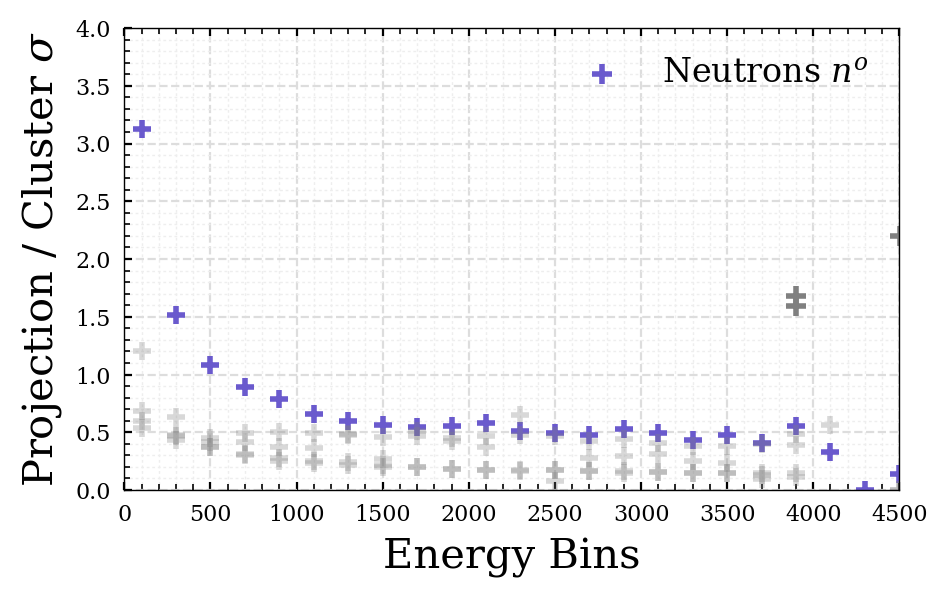

In [33]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = ['neutrons']
plot_clust_resolution_ecal(fig, ax, 'neutrons', xy, binwidth=binwidth, erg_max=5e3)
plot_clust_resolution_ecal_others(fig, ax, part_particles_list, xy, binwidth=binwidth, erg_max=5e3)
ax.set_xlim(0, 4.5e3)
ax.set_ylim(0, 4)
ax.legend(fontsize=12)
plt.show()

## HCal Resolution

In [34]:
binwidth = 200
xy = 'y'

In [35]:
def plot_clust_resolution_hcal(fig, ax, particles_name, xy='x', marker='+', color='slateblue', binwidth=200, size=50, erg_max=5e3, alpha=1, label=True):
    import scipy.stats as stats

    """Grab the Numbers"""
    particles = both_particles_dict[particles_name]
    # set the reconstructed energy
    erg_recon = particles.get('PFCandidates_hcalEnergy_o1corr')
    # ratio of cluster resolution
    """Switch"""
    if xy in ['y', 'Y']:
        track_Px = particles.get('PFCandidates_trackPy')
        track_posX = particles.get('PFCandidates_posEcalY')
        ecal_clusterX = particles.get('PFCandidates_ecalClusterY')
        ecal_clusterEX = particles.get('PFCandidates_ecalClusterEY')
        ecal_clusterDXDZ = particles.get('PFCandidates_ecalClusterDYDZ')
        hcal_clusterX = particles.get('PFCandidates_hcalClusterY')
        hcal_clusterEX = particles.get('PFCandidates_hcalClusterEY')
        hcal_clusterDXDZ = particles.get('PFCandidates_hcalClusterDYDZ')
    else:
        track_Px = particles.get('PFCandidates_trackPx')
        track_posX = particles.get('PFCandidates_posEcalX')
        ecal_clusterX = particles.get('PFCandidates_ecalClusterX')
        ecal_clusterEX = particles.get('PFCandidates_ecalClusterEX')
        ecal_clusterDXDZ = particles.get('PFCandidates_ecalClusterDXDZ')
        hcal_clusterX = particles.get('PFCandidates_hcalClusterX')
        hcal_clusterEX = particles.get('PFCandidates_hcalClusterEX')
        hcal_clusterDXDZ = particles.get('PFCandidates_hcalClusterDXDZ')
    track_Pz = particles.get('PFCandidates_trackPz')
    ecal_clusterZ = particles.get('PFCandidates_ecalClusterZ')
    # ecal_clusterEZ = particles.get('PFCandidates_ecalClusterEZ')
    hcal_clusterZ = particles.get('PFCandidates_hcalClusterZ')
    # hcal_clusterEZ = particles.get('PFCandidates_hcalClusterEZ')

    # track angle
    track_tan = track_Px/track_Pz
    # ecal angle
    ecal_tan = ecal_clusterDXDZ
    # average angle
    avg_tan = np.mean([track_tan, ecal_tan], axis=0)

    # hcal angle
    # hcal_tan = hcal_clusterDXDZ
    proj_distZ = hcal_clusterZ - ECALZ_MIN  # distance calculation is the same
    proj_distX = proj_distZ * avg_tan
    proj_hcalX = track_posX + proj_distX  # the projected x position on hcal plane
    proj_EX = hcal_clusterX - proj_hcalX  # difference between projected and cluster position
    # the number for each bin
    proj_rms = proj_EX/hcal_clusterEX
    
    """Bin"""
    # filter outliers
    proj_rms, erg_recon = plotting._clean_data(proj_rms, erg_recon)

    X = erg_recon
    Y = proj_rms
    # get bins
    XY_bins = np.arange(start=0, stop=erg_max, step=binwidth) # bins, including last element
    XY_bins = np.append(XY_bins, XY_bins[-1] + binwidth)
    
    # define percentile functions
    def _16(arr): return np.quantile(arr, .159) # sigma CI
    def _84(arr): return np.quantile(arr, .841)
    def _05(arr): return np.quantile(arr, .025) # 95%, close to 2 sigma CI
    def _95(arr): return np.quantile(arr, .975)
    XY_med = stats.binned_statistic(X, Y, statistic=np.median, bins=XY_bins)[0] # median
    XY_16 = stats.binned_statistic(X, Y, statistic=_16, bins=XY_bins)[0] # percentiles
    XY_84 = stats.binned_statistic(X, Y, statistic=_84, bins=XY_bins)[0]
    XY_05 = stats.binned_statistic(X, Y, statistic=_05, bins=XY_bins)[0]
    XY_95 = stats.binned_statistic(X, Y, statistic=_95, bins=XY_bins)[0]
    XY_bins_avg = [(a + b) / 2 for a, b in zip(XY_bins[::], XY_bins[1::])] # average of two consecutive elements in bins

    part_label = labels_dict[particles_name] if label else ''
    plotting.scatter(fig, ax, XY_bins_avg, (XY_84 - XY_16)/2, s=40, lw=2, c=color, a=alpha, label=part_label, xlabel='HCal Energy Bins', ylabel=r'Projection / Cluster $\sigma$')

full_particles_list = [
    'electrons',
    'photons',
    'neutrons',
    'pions',
    'protons'
]

def plot_clust_resolution_hcal_others(fig, ax, particles_list, xy='x', binwidth=200, erg_max=5e3):
    other_particles_list = []
    for particles in full_particles_list:
        # add every particle not in the list to plot
        if particles not in particles_list:
            other_particles_list.append(particles)
    
    # all other particles
    for particles in other_particles_list:
        plot_clust_resolution_hcal(fig, ax, particles, xy=xy, binwidth=binwidth, erg_max=5e3, color='gray', alpha=0.3, label=False)

### Electrons

Axes limits [100.0, 700.0] and [0.0, 8.149485016426155]
Axes limits [100.0, 1700.0] and [0.0, 8.210074203306917]
Axes limits [100.0, 4700.0] and [0.0, 1.468705201329246]
Axes limits [100.0, 4700.0] and [0.0, 6.232850399050539]
Axes limits [100.0, 4100.0] and [0.0, 1.4732278926850482]


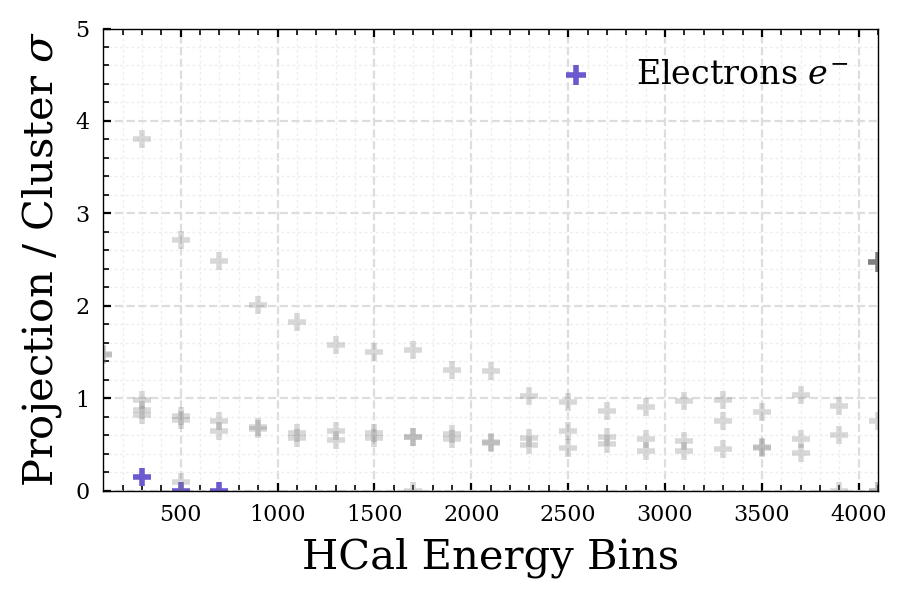

In [36]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = ['electrons']
plot_clust_resolution_hcal(fig, ax, 'electrons', xy, binwidth=binwidth, erg_max=5e3)
plot_clust_resolution_hcal_others(fig, ax, part_particles_list, xy, binwidth=binwidth, erg_max=5e3)
ax.set_ylim(0, 5)
ax.legend(fontsize=12)
plt.show()

### Photons

Axes limits [100.0, 1700.0] and [0.0, 8.210074203306917]
Axes limits [100.0, 700.0] and [0.0, 8.149485016426155]
Axes limits [100.0, 4700.0] and [0.0, 1.468705201329246]
Axes limits [100.0, 4700.0] and [0.0, 6.232850399050539]
Axes limits [100.0, 4100.0] and [0.0, 1.4732278926850482]


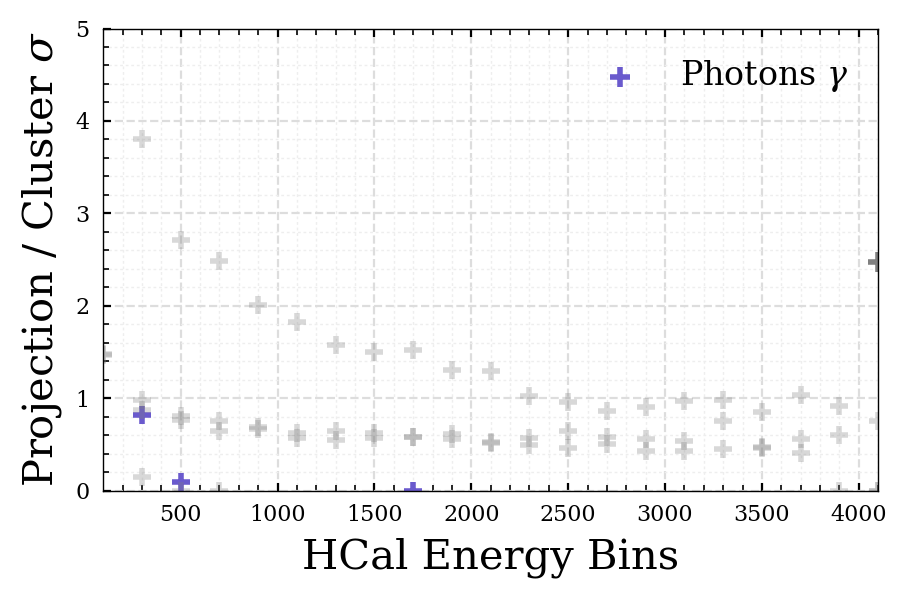

In [37]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = ['photons']
plot_clust_resolution_hcal(fig, ax, 'photons', xy, binwidth=binwidth, erg_max=5e3)
plot_clust_resolution_hcal_others(fig, ax, part_particles_list, xy, binwidth=binwidth, erg_max=5e3)
ax.set_ylim(0, 5)
ax.legend(fontsize=12)
plt.show()

### Pions

Axes limits [100.0, 4700.0] and [0.0, 6.232850399050539]
Axes limits [100.0, 700.0] and [0.0, 8.149485016426155]
Axes limits [100.0, 1700.0] and [0.0, 8.210074203306917]
Axes limits [100.0, 4700.0] and [0.0, 1.468705201329246]
Axes limits [100.0, 4100.0] and [0.0, 1.4732278926850482]


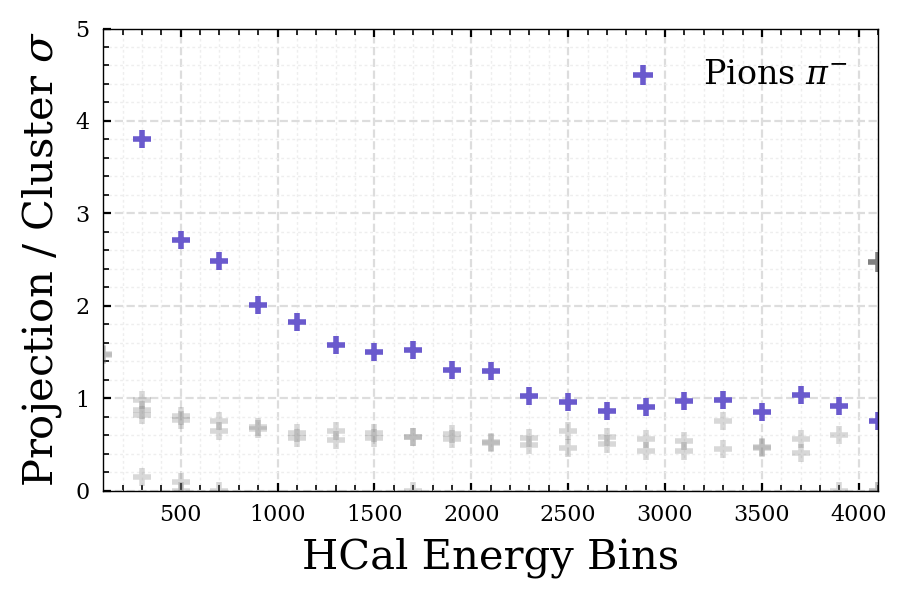

In [38]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = ['pions']
plot_clust_resolution_hcal(fig, ax, 'pions', xy, binwidth=binwidth, erg_max=5e3)
plot_clust_resolution_hcal_others(fig, ax, part_particles_list, xy, binwidth=binwidth, erg_max=5e3)
ax.set_ylim(0, 5)
ax.legend(fontsize=12)
plt.show()

### Protons

Axes limits [100.0, 4100.0] and [0.0, 1.4732278926850482]
Axes limits [100.0, 700.0] and [0.0, 8.149485016426155]
Axes limits [100.0, 1700.0] and [0.0, 8.210074203306917]
Axes limits [100.0, 4700.0] and [0.0, 1.468705201329246]
Axes limits [100.0, 4700.0] and [0.0, 6.232850399050539]


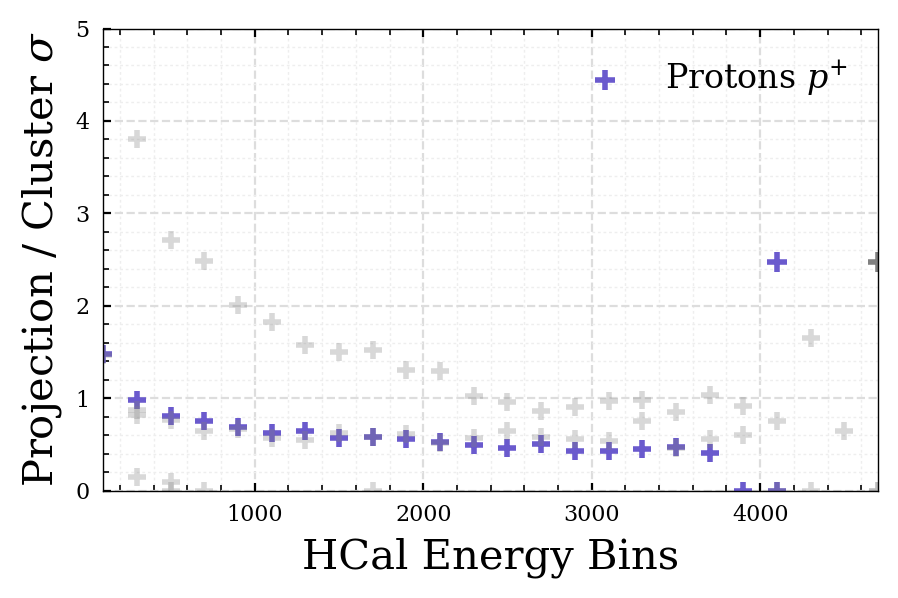

In [39]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = ['protons']
plot_clust_resolution_hcal(fig, ax, 'protons', xy, binwidth=binwidth, erg_max=5e3)
plot_clust_resolution_hcal_others(fig, ax, part_particles_list, xy, binwidth=binwidth, erg_max=5e3)
ax.set_ylim(0, 5)
ax.legend(fontsize=12)
plt.show()

### Neutrons

Axes limits [100.0, 4700.0] and [0.0, 1.468705201329246]
Axes limits [100.0, 700.0] and [0.0, 8.149485016426155]
Axes limits [100.0, 1700.0] and [0.0, 8.210074203306917]
Axes limits [100.0, 4700.0] and [0.0, 6.232850399050539]
Axes limits [100.0, 4100.0] and [0.0, 1.4732278926850482]


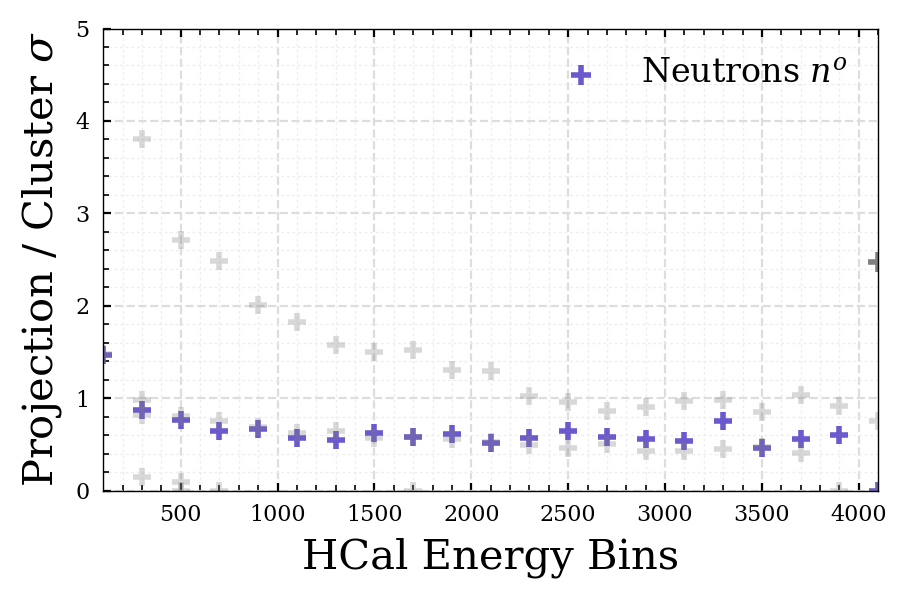

In [40]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = ['neutrons']
plot_clust_resolution_hcal(fig, ax, 'neutrons', xy, binwidth=binwidth, erg_max=5e3)
plot_clust_resolution_hcal_others(fig, ax, part_particles_list, xy, binwidth=binwidth, erg_max=5e3)
ax.set_ylim(0, 5)
ax.legend(fontsize=12)
plt.show()

# Cluster Center & Energy

In [41]:
def comp_weight_dist(part, prop, xlim=None, nbins=100, ylim=None):
    if 'hcal' in part:
        uw_pdict = uw_hcal_particles_dict
        pdict = hcal_particles_dict
    else:
        uw_pdict = uw_both_particles_dict
        pdict = both_particles_dict
    prop_unweighted = uw_pdict[part].get(prop)
    prop_weighted = pdict[part].get(prop)
    prop_weighted = prop_weighted[~np.isnan(prop_weighted)]

    match prop:
        case 'PFCandidates_ecalClusterZ': label = 'Ecal Cluster Z Position'
        case 'PFCandidates_ecalClusterEZ': label = 'Ecal Cluster EZ'
        case 'PFCandidates_ecalClusterX': label = 'Ecal Cluster X Position'
        case 'PFCandidates_ecalClusterEX': label = 'Ecal Cluster EX'
        case 'PFCandidates_hcalClusterZ': label = 'Hcal Cluster Z Position'
        case 'PFCandidates_hcalClusterEZ': label = 'Hcal Cluster EZ'
        case 'PFCandidates_hcalClusterX': label = 'Hcal Cluster X Position'
        case 'PFCandidates_hcalClusterEX': label = 'Hcal Cluster EX'
    
    fig, ax = plt.subplots(figsize=(5, 2), dpi=200)
    plotting.hist(fig, ax, [prop_unweighted, prop_weighted], ['Unweighted', 'Weighted'], nbins=nbins,
                  draw_quartiles=True, xlabel=label, ylabel='Density')
    ax.annotate(text=labels_dict[part], xy=(-50, -30), xycoords='axes points', fontsize=10, weight='bold')
    # set axis limits
    # set the x limit if none is provided
    if not xlim:
        xlim = [np.min([np.nanmin(prop_unweighted), np.nanmin(prop_weighted)]),
                np.max([np.nanmax(prop_unweighted), np.nanmax(prop_weighted)])]
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
    ax.set_xlim(xlim[0], xlim[1])
    plt.legend(loc='best')
    plt.show()
# check minimum and maximum values
clust_ecalZ = lambda x : np.sum(~np.isnan(x.get('PFEcalClusters_centroidZ')))
clust_ecalEZ = lambda x : np.sum(~np.isnan(x.get('PFEcalClusters_rmsZ')))
cand_ecalZ = lambda x : np.sum(~np.isnan(x.get('PFCandidates_ecalClusterZ')))
cand_ecalEZ = lambda x : np.sum(~np.isnan(x.get('PFCandidates_ecalClusterEZ')))
for part in both_particles_dict.values():
    print(clust_ecalZ(protons), clust_ecalEZ(protons), cand_ecalZ(protons), cand_ecalEZ(protons))

10000 10000 10000 10000
10000 10000 10000 10000
10000 10000 10000 10000
10000 10000 10000 10000
10000 10000 10000 10000


## Case study: Pions

In [42]:
_ = pions.list_props()

Property Name                 Number of Entries   Unique Entries      Range                         Mean
PFEcalClusters_hitIDs         10000               1                   0.00          0.00            0.00
PFEcalClusters_energy         10000               9986                0.00       8790.67            621.16
PFEcalClusters_nHits          10000               79                  0.00        115.00            31.16
PFEcalClusters_centroidX      10000               9991                -189.05     208.84            -16.29
PFEcalClusters_centroidY      10000               9985                -207.02     206.59            0.93
PFEcalClusters_centroidZ      10000               9961                0.00        580.63            470.76
PFEcalClusters_rmsX           10000               9982                0.00        184.88            22.63
PFEcalClusters_rmsY           10000               9980                0.00        134.60            21.96
PFEcalClusters_rmsZ           10000           

In [43]:
def comp_weight_dist(part, prop, xlim=None, nbins=100, ylim=None, energy=[0, 5, 'PFCandidates_hcalEnergy_o1corr']):
    if 'hcal' in part:
        uw_pdict = uw_hcal_particles_dict
        pdict = hcal_particles_dict
    else:
        uw_pdict = uw_both_particles_dict
        pdict = both_particles_dict
    # get the masks
    uwmask = np.logical_and(uw_pdict[part].get(energy[2]) > energy[0]*1e3, uw_pdict[part].get(energy[2]) < energy[1]*1e3)
    wmask = np.logical_and(pdict[part].get(energy[2]) > energy[0]*1e3, pdict[part].get(energy[2]) < energy[1]*1e3)
        
    prop_unweighted = uw_pdict[part].get(prop)[uwmask]
    prop_weighted = pdict[part].get(prop)[wmask]
    prop_weighted = prop_weighted[~np.isnan(prop_weighted)]

    match prop:
        case 'PFCandidates_ecalClusterZ': label = 'Ecal Cluster Z Position'
        case 'PFCandidates_ecalClusterEZ': label = 'Ecal Cluster EZ'
        case 'PFCandidates_ecalClusterX': label = 'Ecal Cluster X Position'
        case 'PFCandidates_ecalClusterEX': label = 'Ecal Cluster EX'
        case 'PFCandidates_hcalClusterZ': label = 'Hcal Cluster Z Position'
        case 'PFCandidates_hcalClusterEZ': label = 'Hcal Cluster EZ'
        case 'PFCandidates_hcalClusterX': label = 'Hcal Cluster X Position'
        case 'PFCandidates_hcalClusterEX': label = 'Hcal Cluster EX'
    
    fig, ax = plt.subplots(figsize=(5, 2), dpi=200)
    plotting.hist(fig, ax, [prop_unweighted, prop_weighted], ['Unweighted', 'Weighted'], nbins=nbins,
                  draw_quartiles=True, xlabel=label, ylabel='Density')
    ax.annotate(text=labels_dict[part], xy=(-50, -30), xycoords='axes points', fontsize=10, weight='bold')
    # set axis limits
    # set the x limit if none is provided
    if not xlim:
        xlim = [np.min([np.nanmin(prop_unweighted), np.nanmin(prop_weighted)]),
                np.max([np.nanmax(prop_unweighted), np.nanmax(prop_weighted)])]
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
    ax.set_xlim(xlim[0], xlim[1])
    plt.legend(loc='best')
    plt.show()

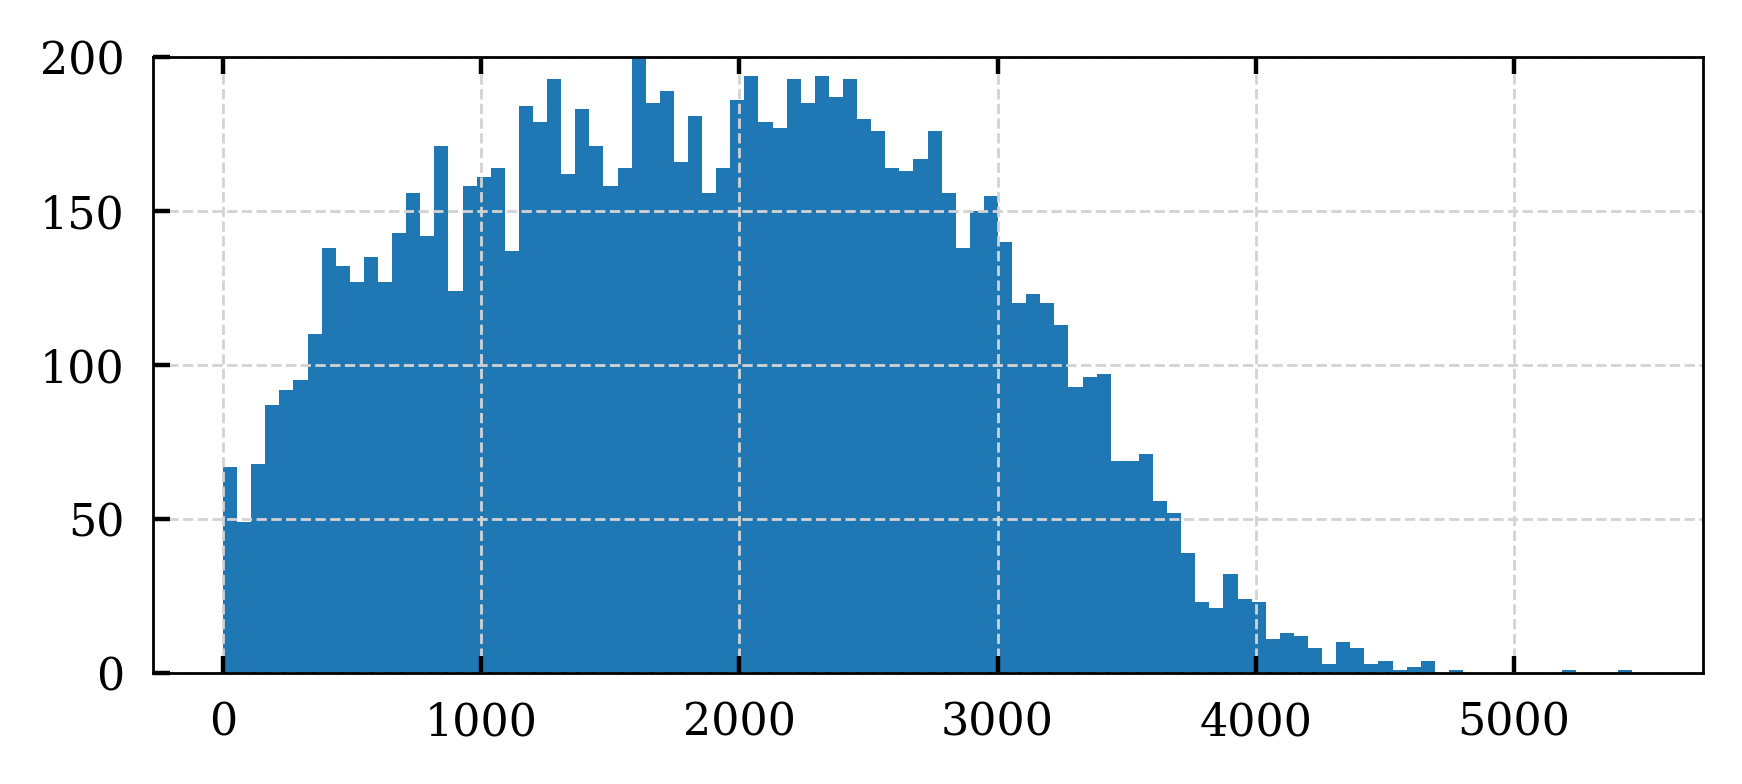

In [87]:
plt.figure(figsize=(5, 2))
plt.hist(pions_hcal.get('PFCandidates_hcalEnergy_o1corr'))
plt.ylim(0, 200)
plt.show()

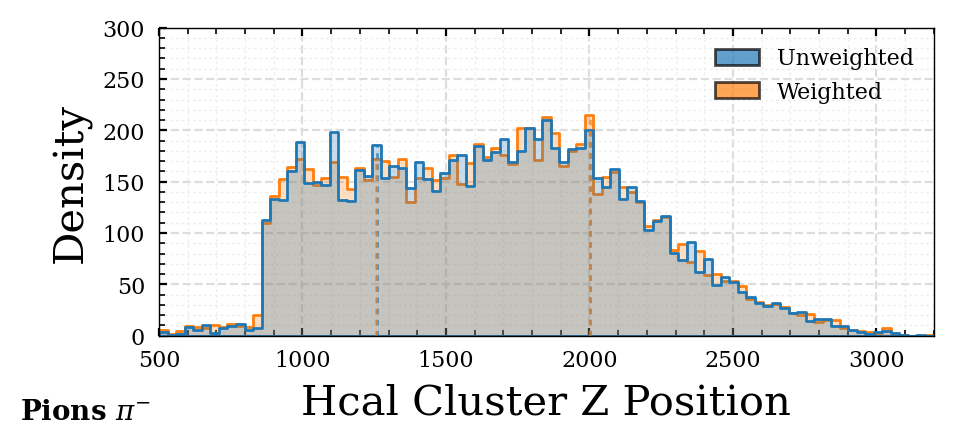

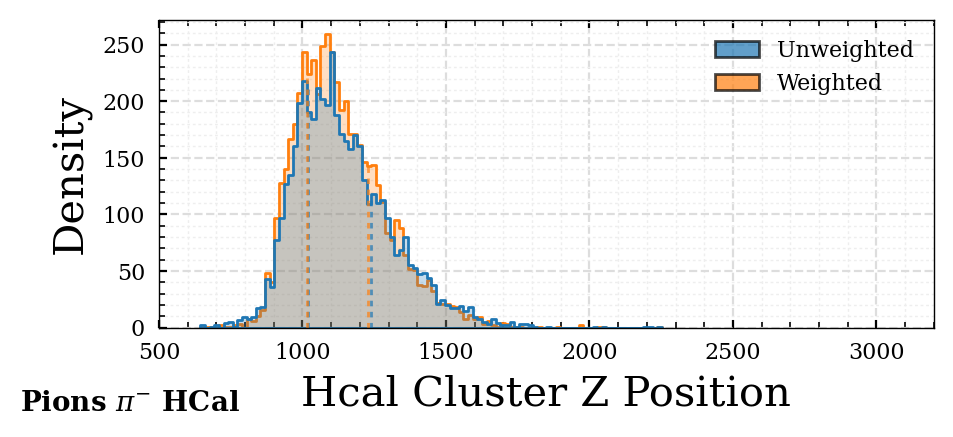

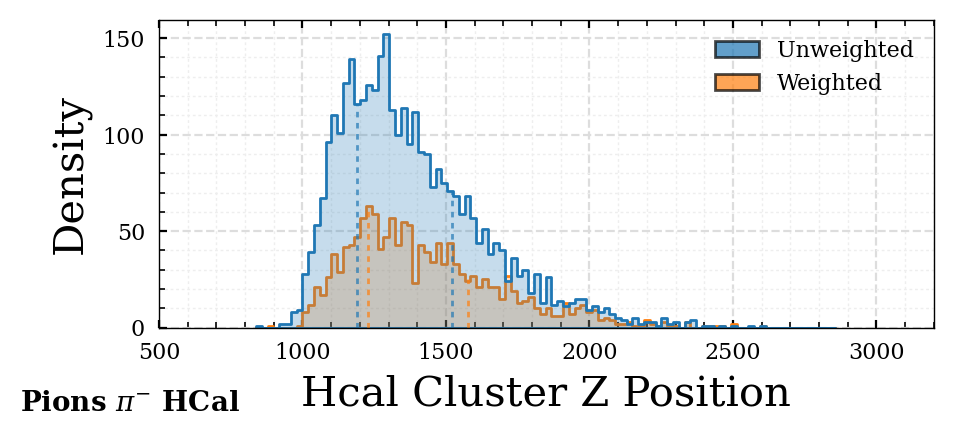

In [81]:
comp_weight_dist('pions', 'PFCandidates_hcalClusterZ', xlim=[500, 3200], ylim=[0, 300])
comp_weight_dist('pions_hcal', 'PFCandidates_hcalClusterZ', [500, 3200], nbins=100, energy=[0, 2, 'PFCandidates_hcalEnergy_o1corr'])
comp_weight_dist('pions_hcal', 'PFCandidates_hcalClusterZ', [500, 3200], nbins=100, energy=[3, 5, 'PFCandidates_hcalEnergy_o1corr'])

## Case study: Protons

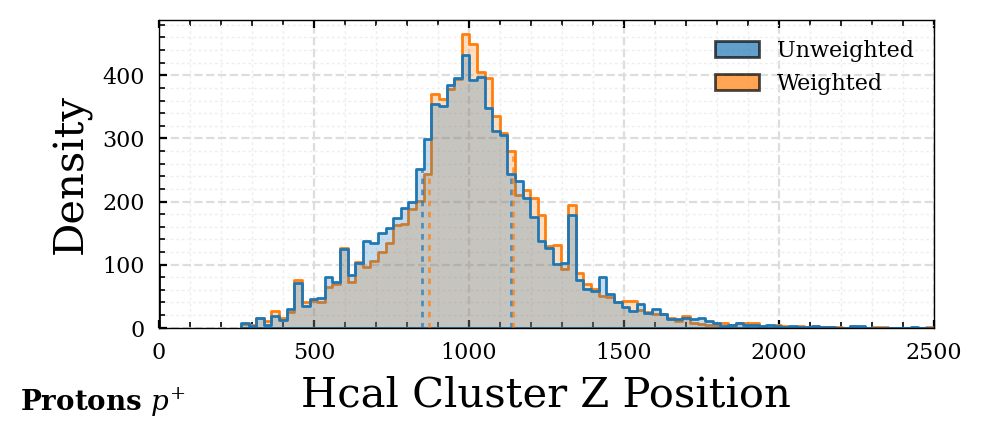

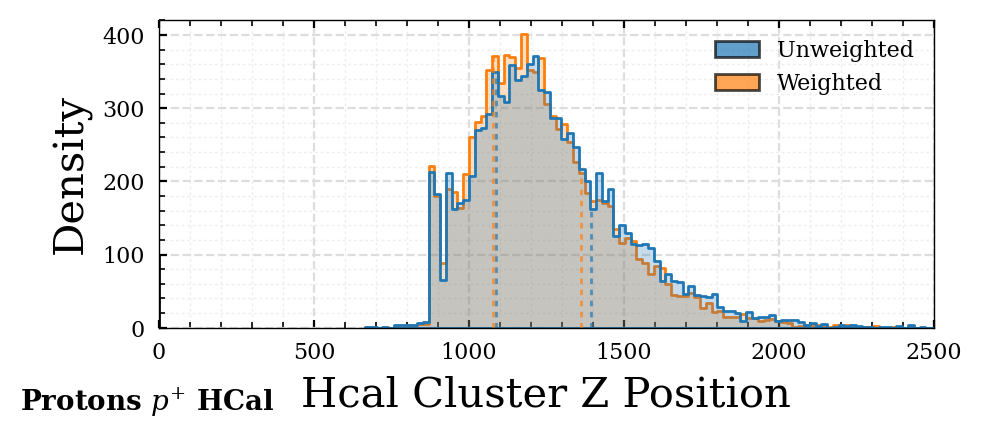

In [54]:
comp_weight_dist('protons', 'PFCandidates_hcalClusterZ', xlim=[0, 2500])
comp_weight_dist('protons_hcal', 'PFCandidates_hcalClusterZ', [0, 2500], nbins=100, energy=[0, 5, 'PFCandidates_hcalEnergy_o1corr'])

## Other Particles

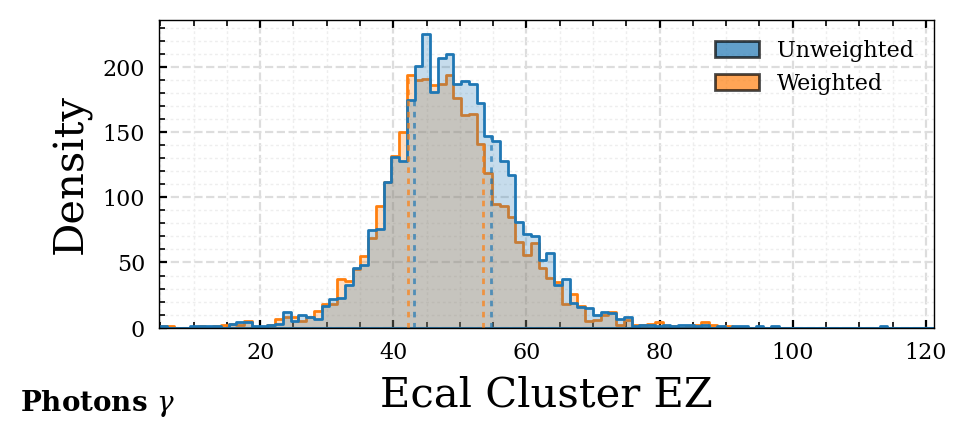

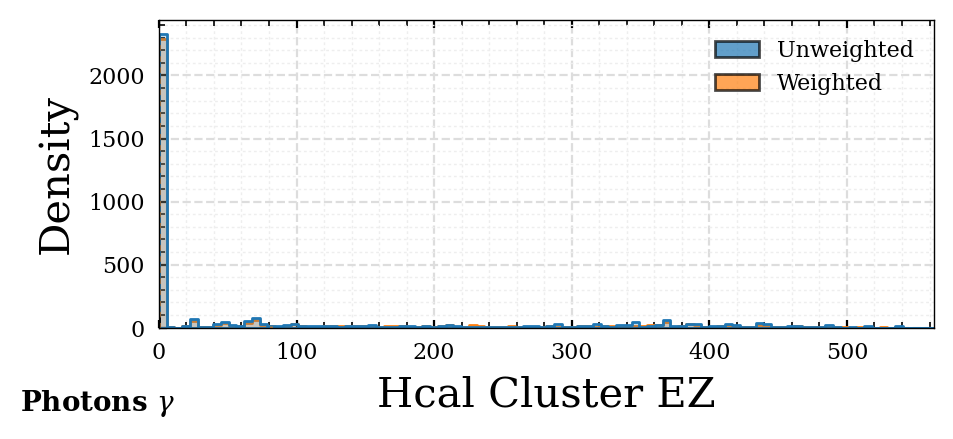

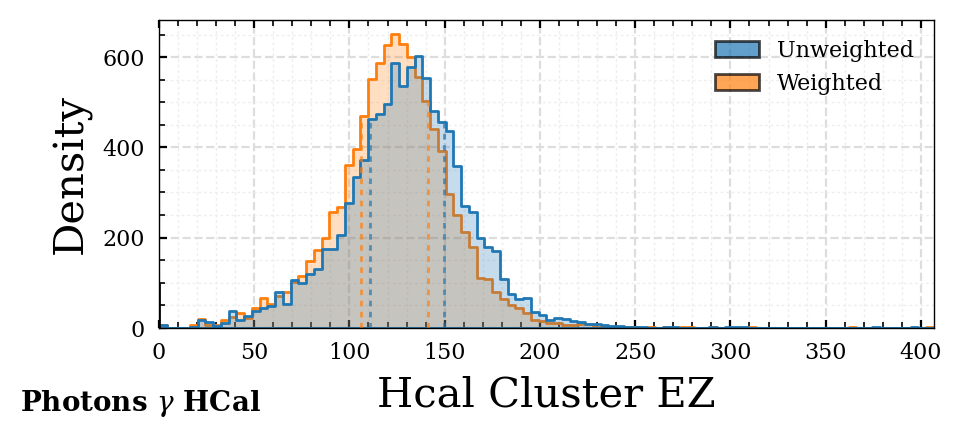

In [92]:
other_particle = 'photons'
# comp_weight_dist(other_particle, 'PFCandidates_ecalClusterZ')
comp_weight_dist(other_particle, 'PFCandidates_ecalClusterEZ')
# comp_weight_dist(other_particle, 'PFCandidates_hcalClusterZ')
comp_weight_dist(other_particle, 'PFCandidates_hcalClusterEZ')
# comp_weight_dist(other_particle+'_hcal', 'PFCandidates_hcalClusterZ')
comp_weight_dist(other_particle+'_hcal', 'PFCandidates_hcalClusterEZ')

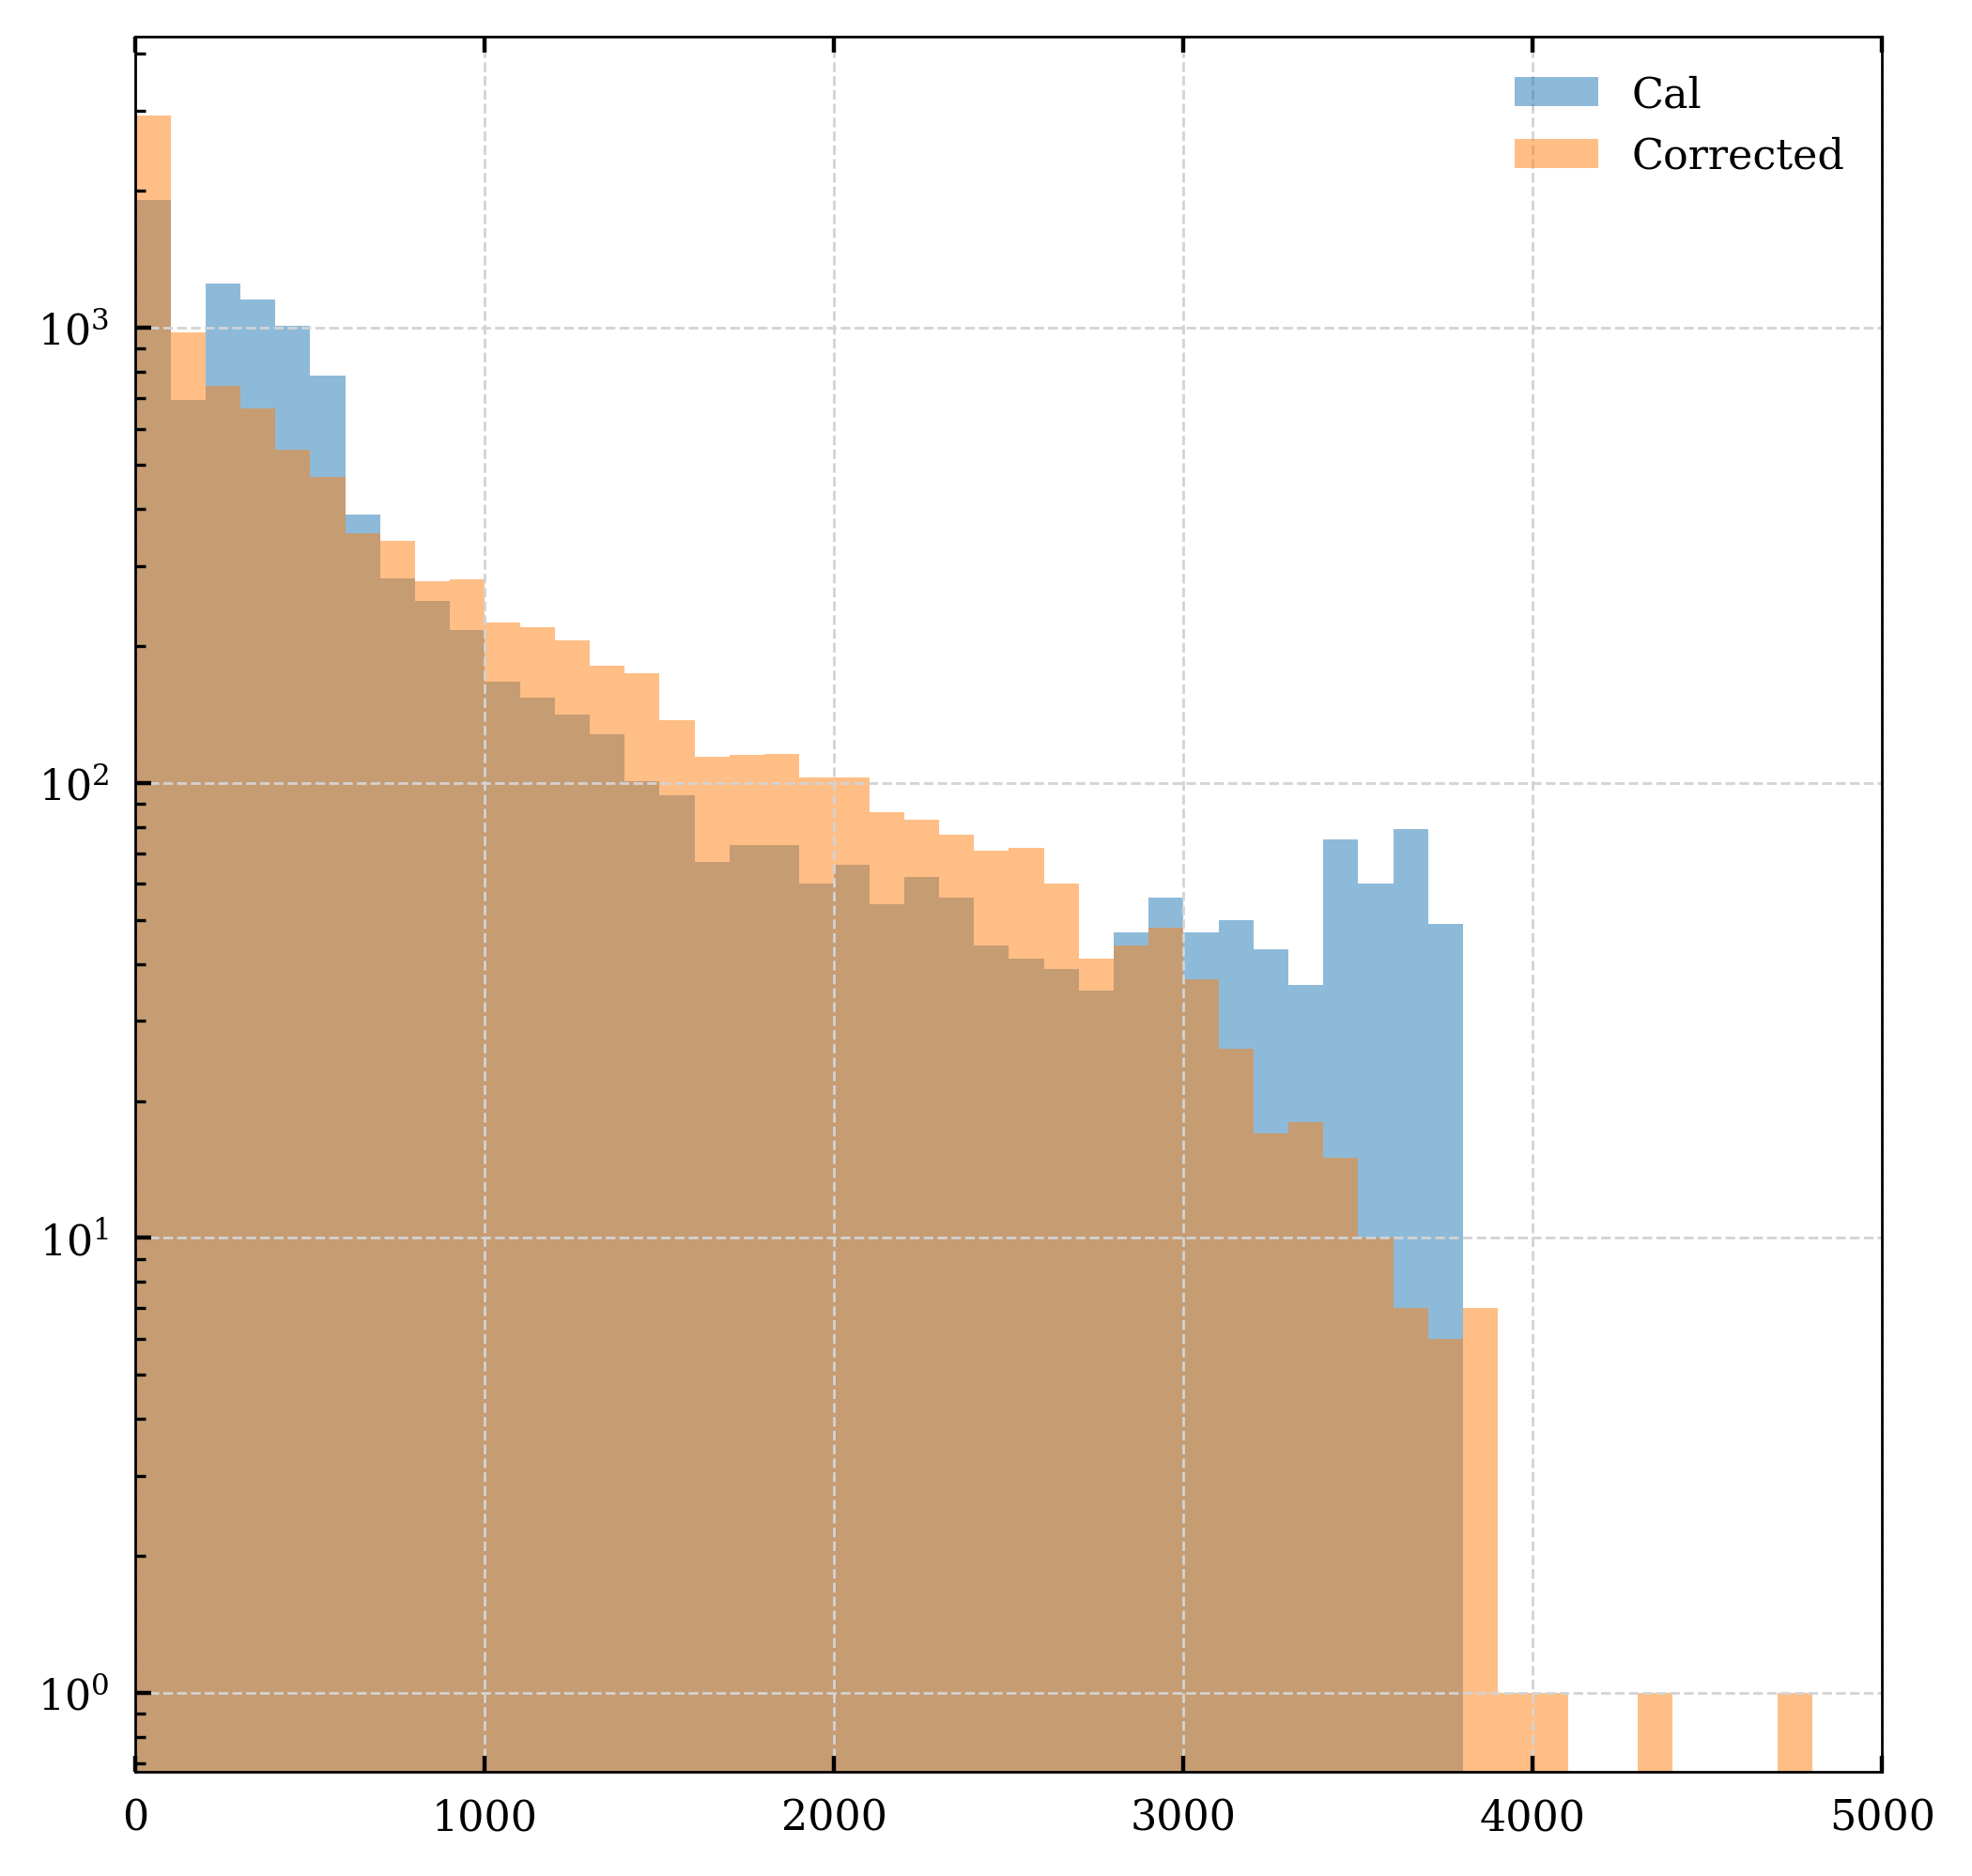

In [75]:
plt.hist(neutrons.get('PFCandidates_hcalCalEnergy'), label='Cal', bins=np.arange(0, 5e3, 100), alpha=0.5)
plt.hist(neutrons.get('PFCandidates_hcalEnergy_o1corr'), label='Corrected', bins=np.arange(0, 5e3, 100), alpha=0.5)
plt.xlim(0, 5e3)
plt.yscale('log')
plt.legend()
plt.show()